In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Preconditioner Comparison

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.

This code was built using `numpy 1.26.4`, `pandas 2.2.3`, `scipy 1.15.1`.
</div>

In [1]:
# Packages
import numpy  as np
import pandas as pd
import scipy.sparse as sparse
from scipy       import version as sp_v

import time
import itertools

#import imageio
#from   skimage.transform import resize
from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator

In [2]:
print('NumPy: {0}, Pandas: {1}, SciPy: {2} '.format(np.__version__, pd.__version__, sp_v.full_version))

NumPy: 1.26.4, Pandas: 2.2.3, SciPy: 1.15.1 


<div class="alert alert-block alert-success">
We solve the following scalar nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2} \|u-u^T\|^2_{0,\Omega} =: f(\lambda)
    \\
    \text{subject to}\qquad
    \\
        & (u,\phi)_V + \big( \lambda(u-f), \phi \big) = 0, &\forall \phi \in V.
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $L$ and the feature patches $\mathcal{W}_\ell [f]$.

In [3]:
import fastadj

In [4]:
"""Local packages"""
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [5]:
# Aliases
from scipy.linalg        import solve
from scipy.sparse.linalg import LinearOperator, eigsh, cg
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe

from imageio             import imwrite, imread
from pandas              import DataFrame
# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     = sparse.linalg.lgmres

In [6]:
# More aliases
from skimage           import data, img_as_float
from skimage.io        import imsave
from skimage.transform import rescale
from skimage.exposure  import rescale_intensity
from sklearn.metrics.pairwise import rbf_kernel

from IPython.display          import Latex

<div class="alert alert-block alert-info">
We load one image from the data set.
</div>

In [7]:
image  = data.cat()[:,:,1][:,15:390]
image  = 255 * img_as_float(rescale_intensity(image, out_range='uint8'))        # imsave('cat.png', image.astype(np.uint8))

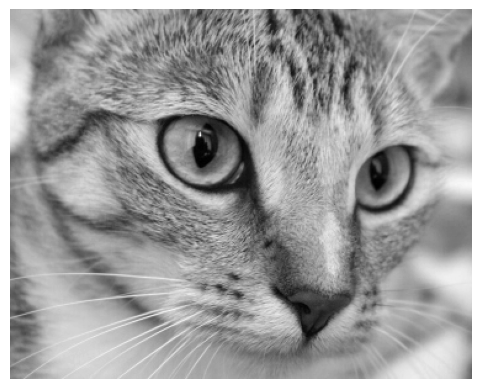

In [8]:
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()

In [9]:
np.float64(1).itemsize * image.size**2 // (1024**3)    # If scale = 1, this is how many GB in memory would be required to store the dense matrix

94

# Additional setups

We tune some parameters to check on the efficiency of the method:

In [10]:
clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')                       # Instiatate the kernel ridge inner functions
def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())    # Quality measure

In [11]:
#0.327 # Limit to this scale for initial test, then go wild
Scales = np.r_[0.1, np.logspace(-1.5, np.log(0.327), 4, base = np.exp(1))]

In [12]:
print('–'*18)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print('{0:4d} {1:4d} {2:5d}'.format(N,M,nm))
print('–'*18)

––––––––––––––––––
  30   38  1140
  67   84  5628
  76   95  7220
  86  108  9288
  98  123 12054
––––––––––––––––––


In [13]:
# Invariant parameters
ρ = 5            # Patch radius
ρ̂ = 2*ρ+1        # Patch length
σ = 30.0         # Invariant region
μ = 1e-2         # Scaling

## Working range

In the notebook [Projection - Eigs Plots](http://localhost:8888/notebooks/Neighbourhood%3AANOVA%20-%20Scalar%20%5BProjection%20-%20Eigs%20Plots%20-%20★%5D.ipynb), the following method was chosed to approximate the working range:

1. Define $f_\mathsf{B} = \Big\{ \big\| \max_{i\in [1:n]} (f^{W_\ell})_{i,[1:3]} - \min_{i\in [1:n]} (f^{W_\ell})_{i,[1:3]} \big\| \Big\}_{\ell \in [1:\mathsf{L}]} $.
2. Define $r_\min = \min f_\mathsf{B}$ and $r_\max = \max f_\mathsf{B}$.
3. Define a lower threshold $\varepsilon_\min \ll 1$ for the entries of $\Gamma$ and obtain $\sigma_\min = r_\max \big/ \sqrt{-\log(\varepsilon_\min)}$.
4. Define an upper threshold $\varepsilon_\max \ll 1$ for the entries of $\Gamma$ and obtain $\sigma_\max = r_\min \big/ \sqrt{-\log(1-\varepsilon_\max)}$.

In any case, we are only interested in our defined working range, as the nonlocal operator will only then capture relevant features of the underlying image. We later found that the range $[10,1500]$ seemed to fit well in our computations.
This last comment can be justified as by the definition of $f_\mathsf{B}$, it is not difficult to consider the bounds $r_\min = 255$ and $r_\max = 255 \sqrt{3}$. Then the resulting range will always be inside the named interval.

In [14]:
# Compute bounds
fᵂ = [255.0, 255*np.sqrt(3)]
#print( np.around(fᵂ,2))

ε = 3e-2
σᵁ = min(fᵂ)/np.sqrt(-np.log1p(-3e-2))
print( '{0:.0e}    {1:.2e} {3:.2e}'.format(ε, σᵁ, σᵁ**-2, np.exp(-((σᵁ)**-1 * max(fᵂ) )**2 )  ))
ε = 1e-308
σᴸ = max(fᵂ)/np.sqrt(-np.log(ε))
print( '{0:.0e}   {1:.2f}    {3:.2e}'.format(ε, σᴸ, σᴸ**-2, np.exp(-((σᴸ)**-1 * min(fᵂ) )**2 )  ))

3e-02    1.46e+03 9.13e-01
1e-308   16.59    2.15e-103


## Regularisation value

Before any test is done, we can expect the following from Graph Theory:

$\qquad$ _Let $G$ be a graph and let $H$ be obtained by either adding an edge to $G$ or increasing the weight of an edge in G. Then, all eigenvalues of $G$ are bounded (index-wise in the standard order) by the eigenvalues of $H$._


As $B$ is a scaling of a graph Laplacian, then we can expect a similar behaviour as we subsample the image domain to obtain smaller/larger graph Laplacians. In particular, as the scaling increases, we will see that the smallest eigenvalue will increase as well. Let's observe this for a few scalings:

In [15]:
λ = 1e-9

In [16]:
print('–'*100)
for scale in [0.1, 0.15, 0.23]:
    # Scale image
    print('⊕: {0:.2e} \n'.format(scale))
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( ' N, M, N×M, Γ[GB]:  {0:3d},  {1:3d},  {2:5d},  {3:7.2f}'.format(N, M, nm, ram_size) )
    
    # Create noisy sample
    ## Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    print( ' SSIM:' + 16*' ' + '{0:.2f}'.format( around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))

    
    
    '''
        Kernel Setup
    '''
    
    
    """Patches"""
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    window_scheme = 'mis'
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list
    
    num_windows = len(windows)
    end = time.time()
    print( ' Windows:' + 13*' ' + '{0:d} ({1:.2f} s)'.format( num_windows, end-start ))
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(num_windows):
            AKu += SubKernels[l].apply(u)

        # Multiply each subKernel by its weight and collect into a sum
        AKu *= k_weight

        return AKu
    
    '''Kernel as an explicit object'''
    def Full_W(σ):
        B = np.zeros([nm,nm])
        for l in range(num_windows):
            B += rbf_kernel(X[:,windows[l]], gamma = (σ**-2) )
        B *= k_weight
        np.fill_diagonal(B, 0.0);
        return B
    
    if nm < 10000:
        ANOVA = Full_W(σ)
        
    end = time.time()
    print(' Setup:' + 15*' ' + '{0:.2f} s'.format( end - start ))
    
    '''
        Step 5: Define system
    '''
    η = AK( ones(nm) )
    ff = f.flatten()
    l_u, PA, PB, Pₐ, Pᵦ = empty([5,nm])
    
    def matvec(v):       return μ * (η * v - AK(v)) + λ * v
    A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)
    
    if nm < 10000:
        def matvec_b(v):       return μ * (η * v - ANOVA.dot(v)) + λ * v
        B = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec_b, rmatvec=matvec_b)
        
    # Assemble system matrix
    η = AK(np.ones(nm))
    
    # Approximate numerical range
    E_A = μ * η.max()
    e_A = μ * η.min()
    print(' Ŵᶠᵃˢᵗ(B) - {0}:' +  6*' ' + '{0:.2f}  {1:.2e}'.format( E_A, e_A ) )
    
    # Obtain largest and second smallest eigenvalues at low precision
    E_A = eigsh(A, k = 1, return_eigenvectors=False, maxiter = 4, tol = 1e-3) - λ
    e_A = eigsh(A, k = 2, return_eigenvectors=False, which = 'SA', maxiter = 4, tol = 1e-2, v0 = np.ones(nm)) - λ
    print(' W̃ᶠᵃˢᵗ(B) - {0}:' +  6*' ' + '{0:.2f}  {1:.2e}'.format(E_A.item(), e_A.max()) )
    
    
    if nm < 10000:
        η = ANOVA.dot(np.ones(nm))
        # Approximate numerical range
        E_A = μ * η.max()
        e_A = μ * η.min()
        print(' Ŵᵉˣᵃᶜᵗ(B) - {0}:' +  5*' ' + '{0:.2f}  {1:.2e}'.format( E_A, e_A ) )
        # Obtain largest and second smallest eigenvalues at low precision
        E_A = eigsh(B, k = 1, return_eigenvectors=False) - λ
        e_A = eigsh(B, k = 2, return_eigenvectors=False, which = 'SA', maxiter = 4, tol = 1e-2, v0 = np.ones(nm)) - λ
        print(' Wᵉˣᵃᶜᵗ(B) - {0}:' +  5*' ' + '{0:.2f}  {1:.2e}'.format(E_A.item(), e_A.max()) )
        del ANOVA
    
    print('–'*100 + '\n')

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
⊕: 1.00e-01 

 N, M, N×M, Γ[GB]:   30,   38,   1140,     0.02
 SSIM:                0.82
 Windows:             41 (9.10 s)
 Setup:               1.20 s
 Ŵᶠᵃˢᵗ(B) - {0}:      0.66  3.06e-01
 W̃ᶠᵃˢᵗ(B) - {0}:      0.66  2.12e-01
 Ŵᵉˣᵃᶜᵗ(B) - {0}:     0.66  3.05e-01
 Wᵉˣᵃᶜᵗ(B) - {0}:     0.66  2.12e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

⊕: 1.50e-01 

 N, M, N×M, Γ[GB]:   45,   56,   2520,     0.09
 SSIM:                0.79
 Windows:             41 (11.39 s)
 Setup:               3.33 s
 Ŵᶠᵃˢᵗ(B) - {0}:      1.82  3.78e-01
 W̃ᶠᵃˢᵗ(B) - {0}:      1.82  3.34e-01
 Ŵᵉˣᵃᶜᵗ(B) - {0}:     1.81  3.78e-01
 Wᵉˣᵃᶜᵗ(B) - {0}:     1.81  3.34e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

⊕: 2.30e-01 

 N, M, N×M, Γ[GB]:   69,   86,   5934,     0.52
 SSIM:                0.76
 Wi

Ill conditioned problems surge for $\lambda \leq 10^{-1}$.

In [16]:
# Interval of different values of λ to test preconditioners
Λ = np.r_[logspace(-9,0.0,10), 1.1] #np.sort(np.concatenate( (logspace(-9,0.0,10), np.e*logspace(-9,-1,9), [1.1]) ))
print('[' + ' '.join(['{0:.1e}'.format(λ) for λ in Λ ]) + ']')

[1.0e-09 1.0e-08 1.0e-07 1.0e-06 1.0e-05 1.0e-04 1.0e-03 1.0e-02 1.0e-01 1.0e+00 1.1e+00]


# CG

In [17]:
# Create a counter that will return how many iterations of each method were performed
global g_cg_it
g_cg_it = 0
def solver_call(xk):
    global g_cg_it
    g_cg_it += 1

## Pivoted Cholesky – Nÿstrom

In [18]:
Results = {0.05: { 'Sizes': [], 'A_Eigs': [], 'Solvers': dict() } for scale in Scales}
Results[0.05]['Solvers'] = { 'CG_its': np.zeros([9,Λ.size]), 
                              'Status': np.zeros([9,Λ.size]), 
                              'Timing': np.zeros([9,Λ.size]), 
                              'Errors': np.zeros([9,Λ.size,8])
                            }

In [19]:
pre_list = [[60, 71, 77], [93, 36, 63], [102, 91, 92], [113, 46, 114], [110, 109, 112], [49, 111, 82], [47, 57, 107], [0, 38, 33], [22, 103, 16], 
            [100, 13, 42], [88, 23, 24], [80, 105, 39], [101, 68, 59], [11, 12, 55], [61, 34, 18], [19, 51, 78], [44, 25, 2], [64, 99, 104], [50, 40, 85], 
            [53, 3, 90], [48, 116, 69], [120, 26, 83], [72, 89, 1], [58, 45, 6], [30, 29, 28], [4, 5, 27], [21, 20, 7], [8, 9, 10], [14, 15, 31], 
            [17, 98, 32], [35, 96, 95], [94, 87, 86], [84, 81, 79], [76, 75, 74], [73, 70, 67], [66, 65, 106], [62, 119, 108], [56, 54, 52], [97, 117, 43], 
            [41, 37, 118], [115]]

In [20]:
# Build a matrix and stablish a system
print('–'*100)
scale = 0.05
all_Windows = []

'''
    Step 1: Scaling
'''
print('⊕: {0:.2e} \n'.format(scale))
img = rescale(image, scale, anti_aliasing=True)
img = asarray(img).astype(float, copy = False)
N,M = img.shape
nm  = img.size
ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
print( ' N, M, N×M, Γ[GB]:  {0:3d},  {1:3d},  {2:5d},  {3:7.2f}'.format(N, M, nm, 2*ram_size) )
Results[scale]['Sizes'] = [N, M, nm, ram_size]

'''
    Step 2: Add noise
'''
# Fix seed
rng = default_rng(10)
σ_i = logspace(1,3,5)[3]
f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
print( ' SSIM:' + 16*' ' + '{0:.2f}'.format( around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))



'''
    Step 3: Kernel Setup
'''


"""Patches"""
Fᵖᵃᵈ = pad(f, ρ, mode='constant')
X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)

'''Build windows'''
if 'pre_list' in globals():
    window_scheme = None
else:
    window_scheme = 'mis'

start = time.time()
# determine windows of features by their mis
if window_scheme == 'mis':
    res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
    windows = clf.get_mis_windows(res_idx)
    all_Windows = windows

# windows are built following the feature indices in ascending order
elif window_scheme == 'consec':
    d    = X.shape[1]
    windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

    # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
    if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

# use predefined list of windows of features
elif window_scheme == None:
    windows = pre_list

num_windows = len(windows)
end = time.time()
print( ' Windows:' + 13*' ' + '{0:d} ({1:.2f} s)'.format( num_windows, end-start ))

'''Weights'''
# Select weight creation mode
weight_scheme = 'equally weighted'

# Compute kernel weights: equal weights that sup up to 1 or no weighting:
k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

# Store weights efficiently as a view
weights = broadcast_to(k_weight, (num_windows, ))


'''Kernel as abstract object'''
def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
    '''
    Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

    Note
    ----
    Using the NFFT-approach, the kernel matrices are never computed explicitly.

    Parameters
    ----------
    X : ndarray
        The training data matrix.
    σ : float
        Shape of the kernel.
    n : even int
        The NFFT expansion degree.
    m : int ≤ max(N,M)
        Window cutoff.
    p : int
        Smoothness of the window function.

    Returns
    -------
    SubKernels : list of fastadj.AdjacencyMatrix
        Subkernel matrices for each window of features according to the selected window scheme.
    '''

    # Bound on window cutoff [Lemma 3.4]
    if n < max([4*m,12]):
        print('Changing n = {} to {}'.format(n, max([4*m,12])))
        n = max([4*m,12])

    # Setup approximation parameters
    NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

    # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
    return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]

'''
    Step 4: Define Kernel
'''
start = time.time()
SubKernels = W(σ, Other_Setup = 'default')

def AK(u):
    """
    Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

    Note
    ----
    Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
    Any other variable needed has to be global, so that they can still be used within this function

    Parameters
    ----------
    u : ndarray
        The vector, whose product AK*u with the matrix AK shall be approximated.

    Returns
    -------
    AKu : ndarray
        The approximated matrix-vector product AK*u.
    """

    # Apply matrix-vector multiplication
    AKu = np.zeros_like(u)
    for l in range(num_windows):
        AKu += SubKernels[l].apply(u)

    # Multiply each subKernel by its weight and collect into a sum
    AKu *= k_weight

    return AKu

end = time.time()
print(' Setup:' + 15*' ' + '{0:.2f} s'.format( end - start ))

'''
    Step 5: Define system
'''
η = AK( ones(nm) )
ff = f.flatten()
l_u, PA, PB, PC, PE = empty([5,nm])

def matvec(v):       return μ * (η * v - AK(v)) + λ * v
A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)

# Also define Σ ΓoΓ for ℓ_2 preconditioner
SubKernels_Precond = W(σ/(2**0.5), Other_Setup = 'default')
PC = weights.dot(asarray([SubKernels_Precond[l].apply( ones(nm) ) for l in range(num_windows)]))
PD = PC.copy()    # Third option [not in paper but in thesis]
PC *= k_weight

# Assemble system matrix
η = AK(np.ones(nm))

# Approximate numerical range
E_A = μ * η.max()
e_A = μ * η.min()
print(' Ŵᶠᵃˢᵗ(B) - {0}:' +  6*' ' + '{0:.2f}  {1:.2e}'.format( E_A, e_A ) )
Results[scale]['A_Eigs'] = [E_A, e_A]


# Basis change only depends on the dimension of the image, so we only have to define it once
not_e_1 = ones(nm);    not_e_1[0] = 0.0

aux_h = np.arange(nm)
aux_d = np.reciprocal(np.sqrt( np.concatenate( ([nm], np.arange(2,nm+1) * np.arange(1,nm) ) ) ))

def MV_basis_U_T(v):       return aux_d * (np.roll( np.cumsum(v),1) - (aux_h * v))
def MV_basis_U(v):
    w = aux_d * v
    return  ((w.sum() - np.cumsum(w)) * np.flip(not_e_1)) - (aux_h * w) + w[0]


'''
    Step 6: Loop over several λ and solve system
'''

# The following are shallow copies for easy access
Time   = Results[scale]['Solvers']['Timing']
Status = Results[scale]['Solvers']['Status']
CG_its = Results[scale]['Solvers']['CG_its']
Errors = Results[scale]['Solvers']['Errors']

# Previous
# solver_max_it = 30, 200
# Current
solver_max_it = 30

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
⊕: 5.00e-02 

 N, M, N×M, Γ[GB]:   15,   19,    285,     0.00
 SSIM:                0.83
 Windows:             41 (0.00 s)
 Setup:               0.04 s
 Ŵᶠᵃˢᵗ(B) - {0}:      0.29  9.80e-02


#### Naïve Nyström

Let's compute a naïve Nyström approximation:

In [22]:
sp_Id = sparse.eye(nm, format='csr')

In [25]:
S = [0,10,15,25,75,100,205]
start = time.time()
A_S  = sparse.diags(η + λ).dot(sp_Id[:,S]).todense()               # Bits from η
A_S -= np.r_[[AK(sp_Id[:,i].toarray().ravel()) for i in S]].T    # Bits from Γ
A_S *= μ                                                       # Scaling
end = time.time()
print(end-start)

1.7812600135803223


Now let's take the Moore–Penrose pseudoinverse:

In [26]:
allclose(A_S.dot(np.linalg.pinv(A_S[S]).dot(A_S[S])), A_S)

True

In [27]:
np.linalg.eigvalsh(A_S.dot(np.linalg.pinv(A_S[S]).dot(A_S.T)))[-7:]    # Only nonzero eigenvalues

array([0.1278358 , 0.1494381 , 0.24262981, 0.2453088 , 0.24754331,
       0.24933001, 0.27064911])

In [28]:
# Qualities tr(A - Â) ≥ 0, tr(A - Â)/tr(A)
(μ * η.sum() + λ*nm) - np.trace(A_S.dot(np.linalg.pinv(A_S[S]).dot(A_S.T))), 1 - np.trace(A_S.dot(np.linalg.pinv(A_S[S]).dot(A_S.T)))/(μ * η.sum() + λ*nm)

(50.87689355113535, 0.970754707148913)

In [29]:
r = np.arange(2,50)

In [30]:
ε_n = 1e-1; η_tr = 1e-3
np.ceil(r/ε_n + r * np.log(1/(ε_n *η_tr))) #, r/ε_n + r * np.max( np.log( (2**r)/ε_n), 0)

array([ 39.,  58.,  77.,  97., 116., 135., 154., 173., 193., 212., 231.,
       250., 269., 289., 308., 327., 346., 365., 385., 404., 423., 442.,
       462., 481., 500., 519., 538., 558., 577., 596., 615., 634., 654.,
       673., 692., 711., 730., 750., 769., 788., 807., 827., 846., 865.,
       884., 903., 923., 942.])

#### Randomised Pivoted Cholesky

In [31]:
def matvec_B(v):       return μ * (η * v - AK(v))
B = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec_B, rmatvec=matvec_B)
# Its diagonal is given by η*μ [by definition]
# a way to compare would be: [B.dot(sp_Id[:,i].toarray().ravel())[i] for i in range(10)] maybe for a longer range, but it is expensive

In [153]:
def rpcholesky(A, diags, k, alg = 'rp', stoptol = 0):
    global sp_Id
    '''
        Input
        ========================
        A::_CustomLinearOperator    SciPy operator representing a graph Laplacian that acts on a n-dimensional real space
                                    Alternatively, we can also work with A::numpy.ndarray 
                                        
        diags::numpy.ndarray        Numpy vector representing the diagonal of A
        
        k::int                      Approximation rank
        b::int or st                Number of random pivots
        alg::str                    Sampling method
        stoptol::float              Tolerance?
        
        Output
        ========================
        F::numpy.ndarray            Nÿstrom approximation factor such that Â = F Fᵀ
        idx::numpy.ndarray          Indices sampled from A, corresponds to S
        rows::numpy.ndarray         A[S,:]
    '''
    
    # Check if instance is correct
    if not ((A.__class__.__name__ == '_CustomLinearOperator') or isinstance(A, np.ndarray)):
        raise NameError('A must be an operator or a matrix.')
    
    # Check if sampling algorithm is recognised, else change to default
    if (not isinstance(alg, str)) or (alg not in ['rp', 'rgreedy', 'greedy']):
        print('Algorithm {} not recognized. Switching to default.'.format(alg))
        alg = 'rp'
    
    # Get dimension of vector space
    n = A.shape[0]
    
    # Check if identity matrix is available
    if 'sp_Id' not in globals():
        sp_Id = sparse.eye(n, format='csr')
    elif sp_Id.shape[0] != n: 
        sp_Id = sparse.eye(n, format='csr')
        
    # If A is an array and diags is empty, we override it
    if not isinstance(diags, np.ndarray):
        # Compute diagonal
        if isinstance(A, np.ndarray):
            diags = A.diagonal()
        # Allow for a constant value to be given
        if isinstance(diags, (float,int, np.float64)):
            diags = diags * np.ones(n)
        # Obtaining the diagonal of the operator would be an O(n^2) operation, for we avoid this
        else: 
            raise NameError('A working diagonal has not been provided.')
               
    # Compute original trace
    orig_trace = diags.sum()
    
    
    # row ordering, is much faster for large scale problems
    G = np.zeros((k,n))
    rows = np.zeros((k,n))
    rng = np.random.default_rng(0)
    
    # Iterate
    arr_idx = []                # Index collector
    for i in range(k):
        # Sample pivot
        if alg == 'rp':
            idx = rng.choice(range(n), p = diags / diags.sum() )      # Probability proportional to residual diagonal
        elif alg == 'rgreedy':
            idx = rng.choice(np.where(diags == diags.max() )[0])
        elif alg == "greedy":
            idx = np.argmax(diags)

        arr_idx.append(idx)
        
        # Sample matrix
        if (A.__class__.__name__ == '_CustomLinearOperator'):
            rows[i,:] = A(sp_Id[:,idx].toarray().ravel())             # Evaluate column of input operator
        else:
            rows[i,:] = A[idx,:]                                      # Evaluate column of input matrix
        
        # Remove overlap with previously chosen columns and update approximation
        G[i,:] = (rows[i,:] - G[:i,idx].T @ G[:i,:]) / np.sqrt(diags[idx])
        
        # Track diagonal of residual matrix
        diags -= G[i,:]**2
        # Ensure diagonal remains nonnegative
        diags = diags.clip(min = 0.0)

        
        # Error control
        if stoptol > 0 and diags.sum() <= stoptol * orig_trace:
            G = G[:i,:]
            rows = rows[:i,:]
            break

            
    return G.T, arr_idx, rows

In [33]:
rank_rpc = max(30, min(1000, int(np.floor(nm * 0.01)) ))
print(rank_rpc)

30


In [34]:
start = time.time()
F,idx,rows = rpcholesky(B, μ*η, rank_rpc, alg = 'rp', stoptol = 0)    # tr(Â) = norm(F, 'fro')**2
end = time.time()
print(np.around(end-start,2))

7.36


In [35]:
# Check trace error
1.0 - norm(F, 'fro')**2/(μ * η.sum())

0.8884747573232814

Now we can assemble an approximation of $(A+\lambda \mathsf{I})^{-1}$ in operator form:

In [36]:
from scipy.linalg import solve

In [37]:
λ = 1e-9

In [38]:
def Chol_Prec(v):
    #global λ
    #print(λ)
    # Solve system instead of computing inverse
    b = F.T.dot(v)
    x = solve( np.diag(λ * np.ones(F.shape[1]), 0) + F.T.dot(F), b, assume_a='pos', check_finite=False )
    # Process solution
    y  = (v - F.dot(x))
    y /= λ
    return y

In [39]:
P_Chol = LinearOperator((nm,nm), dtype=np.float64, matvec=Chol_Prec, rmatvec=Chol_Prec)

In [40]:
for λ in [1e-9, 1, 1e+10]:
    print(SSIM(img, P_Chol(λ * ff), N,M))

0.739988365635378
0.8244132908782192
0.8262295891009533


Now let's use this solver as a preconditioner:

In [41]:
λ = 1e-9

In [51]:
# Update RHS
multiply(λ, ff, out = l_u)
# Precompute some norms
n_lu_2 = norm(l_u);        n_lu_i = norm(l_u, np.inf)

'''
    ––––––––––––––––––––––––––––––––
    No preconditioner
    ––––––––––––––––––––––––––––––––
'''
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = None, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

Time: 7.61 | |Au-λf|: 4.67e-13 | CG: 30


In [52]:
'''
    ––––––––––––––––––––––––––––––––
    RPivChol
    ––––––––––––––––––––––––––––––––
'''
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

# More iterations
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = 100, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

Time: 7.58 | |Au-λf|: 6.31e-06 | CG: 30
Time: 18.45 | |Au-λf|: 2.93e-13 | CG: 73


#### Accelerated Randomised Pivoted Cholesky

We can further try the accelerated Cholesky method instead:

In [55]:
def rejection_cholesky(H):
    b = H.shape[0]
    if H.shape[0] != H.shape[1]:
        raise RuntimeError("rejection_cholesky requires a square matrix")
    if np.trace(H) <= 0:
        raise RuntimeError("rejection_cholesky requires a strictly positive trace")
    u = np.array([H[j,j] for j in range(b)])

    idx = []
    L = np.zeros((b,b))
    for j in range(b):
        if np.random.rand() * u[j] < H[j,j]:
            idx.append(j)
            L[j:,j] = H[j:,j] / np.sqrt(H[j,j])
            H[(j+1):,(j+1):] -= np.outer(L[(j+1):,j], L[(j+1):,j])
    idx = np.array(idx)
    L = L[np.ix_(idx,idx)]
    return L, idx

In [56]:
def accelerated_rpcholesky(A, diags, k, b = "auto", stoptol = 1e-13, verbose=False):
    global sp_Id
    '''
        A::_CustomLinearOperator    SciPy operator representing a graph Laplacian that acts on a n-dimensional real space
                                    Alternatively, we can also work with A::numpy.ndarray 
                                        
        diags::numpy.ndarray        Numpy vector representing the diagonal of A
        
        k::int                      Approximation rank
        b::int or string            Number of random pivots
        
        stoptol::float              Tolerance?
        
        Output
        ========================
        F::numpy.ndarray            Nÿstrom approximation factor such that Â = F Fᵀ
        idx::numpy.ndarray          Indices sampled from A, corresponds to S
        rows::numpy.ndarray         A[S,:]
    '''
    
    # Check if instance is correct
    if not ((A.__class__.__name__ == '_CustomLinearOperator') or isinstance(A, np.ndarray)):
        raise NameError('A must be an operator or a matrix.')
    
    # Get dimension of vector space
    n = A.shape[0]
    
    # Check if identity matrix is available
    if 'sp_Id' not in globals():
        sp_Id = sparse.eye(nm, format='csr')
    
    # If A is an array and diags is empty, we override it
    if not isinstance(diags, np.ndarray):
        # Compute diagonal
        if isinstance(A, np.ndarray):
            diags = A.diagonal()
        # Allow for a constant value to be given
        if isinstance(diags, (float,int, np.float64)):
            diags = diags * np.ones(n)
        # Obtaining the diagonal of the operator would be an O(n^2) operation, for we avoid this
        else: 
            raise NameError('A working diagonal has not been provided.')
    
    # Compute original trace
    orig_trace = diags.sum()

    
    #  I will leave this as pendding
    if "auto" == b:
        b = int(np.ceil(k / 10))
        auto_b = True
    else:
        auto_b = False
        
        
    
    # row ordering
    G, rows = np.zeros((2,k,n))
    
    rng = np.random.default_rng(0)
    arr_idx = np.zeros(k, dtype=int)
    
    
    # Iterate
    counter = 0
    while counter < k:
        idx = rng.choice(range(n), size = b, p = diags / diags.sum(), replace = True)      # Probability proportional to residual diagonal

        if auto_b:
            start = time.time()
        
        # Sample matrix
        if (A.__class__.__name__ == '_CustomLinearOperator'):
            A_S = np.r_[[A(sp_Id[:,i].toarray().ravel()) for i in idx]]             # Evaluate column of input operator
        else:
            A_S = A[idx,:]                                                          # Evaluate column of input matrix
        
        # Rejection sampling
        H = A_S[:,idx] - G[0:counter,idx].T @ G[0:counter,idx]
        L, accepted = rejection_cholesky(H)
        num_sel = len(accepted)
        
        # Update pivots
        if num_sel > k - counter:
            num_sel = k - counter
            accepted = accepted[:num_sel]
            L = L[:num_sel,:num_sel]
        
        if auto_b:
            rejection_time = time.time() - start
            start = time.time()

        # Update low-rank approximation and proposal distribution
        rows[counter:counter+num_sel,:] = A_S[accepted]
        
        idx = idx[accepted]
        arr_idx[counter:counter+num_sel] = idx
        
        G[counter:counter+num_sel,:] = rows[counter:counter+num_sel,:] - G[0:counter,idx].T @ G[0:counter,:]
        G[counter:counter+num_sel,:] = np.linalg.solve(L, G[counter:counter+num_sel,:])
        diags -= np.sum(G[counter:counter+num_sel,:]**2, axis=0)
        diags = diags.clip(min = 0)

        if auto_b:
            process_time = time.time() - start

            # Assuming rejection_time ~ A b^2 and process_time ~ C b
            # then obtaining rejection_time = process_time / 4 entails
            # b = C / 4A = (process_time / b) / 4 (rejection_time / b^2)
            #   = b * process_time / (4 * rejection_time)
            target = int(np.ceil(b * process_time / (4 * rejection_time)))
            b = max([min([target, int(np.ceil(1.5*b)), int(np.ceil(k/3))]),
                     int(np.ceil(b/3)), 10])

        counter += num_sel

        if stoptol > 0 and sum(diags) <= stoptol * orig_trace:
            G = G[:counter,:]
            rows = rows[:counter,:]
            break

        if verbose:
            print("Accepted {} / {}".format(num_sel, b))

    return G.T, arr_idx, rows

In [57]:
start = time.time()
F,idx,rows = accelerated_rpcholesky(B, μ*η, 30, verbose=True)    # tr(Â) = norm(F, 'fro')**2
end = time.time()
print(np.around(end-start,2))

Accepted 3 / 10
Accepted 9 / 10
Accepted 10 / 10
Accepted 8 / 10
8.47


In [58]:
# Check trace error
1.0 - norm(F, 'fro')**2/(μ * η.sum())

0.8862367097786572

In [59]:
for λ in [1e-9, 1, 1e+10]:
    print(SSIM(img, P_Chol(λ * ff), N,M))

0.7780732863097662
0.8253600001472682
0.8262295891010071


In [60]:
λ = 1e-9

In [61]:
'''
    ––––––––––––––––––––––––––––––––
    RPivChol
    ––––––––––––––––––––––––––––––––
'''
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

# More iterations
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = 100, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

Time: 7.66  | |Au-λf|: 3.41e-06 | CG: 30
Time: 18.07 | |Au-λf|: 3.12e-13 | CG: 73


#### Trace norm comparison

In [67]:
print('Err (Time): ', end = '')
for k in [30, 60, 90, 120, 150, 180]:
    start = time.time()
    F,idx,rows = rpcholesky(B, μ*η, k, alg = 'rp', stoptol = 0)    # tr(Â) = norm(F, 'fro')**2
    end = time.time()
    
    tr_err = 1.0 - norm(F, 'fro')**2/(μ * η.sum())
    
    print('{0:^5.2e} ({1:5.2f}) | '.format( tr_err, end-start), end = '')

Err (Time): 8.88e-01 ( 7.39) |7.75e-01 (17.31) |6.67e-01 (27.92) |5.49e-01 (38.86) |4.49e-01 (49.05) |3.34e-01 (61.32) |

In [69]:
print('Err (Time): ', end = '')
for k in [30, 60, 90, 120, 150, 180]:
    start = time.time()
    F,idx,rows = accelerated_rpcholesky(B, μ*η, k, verbose=False)
    end = time.time()
    
    tr_err = 1.0 - norm(F, 'fro')**2/(μ * η.sum())
    
    print('{0:^5.2e} ({1:5.2f}) | '.format( tr_err, end-start), end = '')

Err (Time): 8.86e-01 ( 8.76) | 7.74e-01 (17.43) | 6.68e-01 (26.18) | 5.51e-01 (33.32) | 4.44e-01 (42.26) | 3.34e-01 (51.01) | 

In [70]:
'''
    ––––––––––––––––––––––––––––––––
    RPivChol
    ––––––––––––––––––––––––––––––––
'''
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

# More iterations
g_cg_it = 0
## Solve system
start = time.time()
u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = 100, M = P_Chol, callback = solver_call)
end = time.time()
print('Time: {0:^5.2f} | |Au-λf|: {1:^5.2e} | CG: {2}'.format( end-start, norm(A.dot(u) - l_u), g_cg_it))

Time: 11.09 | |Au-λf|: 8.21e-06 | CG: 30
Time: 24.01 | |Au-λf|: 2.61e-13 | CG: 66


In [94]:
norm(P_Chol(l_u) - u)/norm(u)

0.1270342413017568

## Few scales

In [19]:
#Scales = [0.05]

In [100]:
Results = {scale: { 'Sizes': [], 'A_Eigs': [], 'Solvers': dict() } for scale in Scales}
num_conditioners = 9
for scale in Scales:
    Results[scale]['Solvers'] = { 'CG_its': np.zeros([num_conditioners,Λ.size]), 
                                  'Status': np.zeros([num_conditioners,Λ.size]), 
                                  'Timing': np.zeros([num_conditioners,Λ.size]), 
                                  'Errors': np.zeros([num_conditioners,Λ.size,8])
                                }

We take the following steps in a loop:

* Sample pixels from the image in such a way that the sample is an image itself.
* Create new image from additive noise applied to the clean sample.
* Kernel setup preparation, which includes patch creation, window selection, and weight scheme
* Creation of kernel as an abstract object
* Define abstract operator
* Solve system for different values of $\lambda$ and different preconditioners:

    0. No preconditioner $M^{-1} = \mathsf{I}$   
    1. Diagonal preconditioners
        1. Linear diagonal preconditioner $P_{\mathsf a} = \mathrm{diag}( \mu\eta + \lambda) \mapsto M^{-1} = \mathrm{diag}( P_{\mathsf a}^{-1} )$
        2. $\ell^2$ diagonal preconditioner $P_{\mathsf b} = \bigg[P_{\mathsf a}^{2} + (\mu/\mathsf L)^2 \sum\limits_{\ell=1}^{\mathsf L} (\Gamma_\ell \circ \Gamma_\ell) \mathbb{1}_n\bigg]^{1/2}  \mapsto M^{-1} = \mathrm{diag}( P_{\mathsf b}^{-1})$
        3. Scaled $\ell^2$ diagonal preconditioner $P_{\mathsf c} = \bigg[P_{\mathsf a}^{2} + (\mu^2/\mathsf L) \sum\limits_{\ell=1}^{\mathsf L} (\Gamma_\ell \circ \Gamma_\ell) \mathbb{1}_n\bigg]^{1/2}  \mapsto M^{-1} = \mathrm{diag}( P_{\mathsf c}^{-1})$
    
    2. Unitary basis change to get $ \mathsf{A}_U $ in block form. Here we solve one block exaclty and
        1. solve the other block without preconditioning (includes scaling by $\lambda$), 
        2. solve the other block projecting the action of $P_{\mathsf d}$ by $U$ and projecting it in the sub block $\pi_2( \mathsf{D}_{\mathsf{a}, U}^{-1} )$,
        3. solve the other block projecting the action of the $\ell^2$ diagonal preconditioner under $U$ and projecting it in the sub block $\pi_2( \mathsf{D}_{\mathsf{b}, U}^{-1} )$,
        4. solve the other block projecting the action of the scaled $\ell^2$ diagonal preconditioner under $U$ and projecting it in the sub block $\pi_2( \mathsf{D}_{\mathsf{c}, U}^{-1} )$.

In [113]:
All_Windows = {scale: [] for scale in Scales}

In [120]:
All_Windows[Scales[0]] = [[60, 71, 49], [59, 61, 38], [48, 82, 50], [72, 113, 70], [109, 112, 83], [118, 84, 37], [81, 119, 98], [100, 99, 57], [89, 87, 114],
                          [58, 102, 117], [107, 36, 73], [120, 106, 39], [97, 27, 93], [95, 74, 115], [17, 111, 80], [108, 69, 104], [67, 68, 79], 
                          [103, 76, 101], [85, 14, 4], [110, 86, 2], [15, 91, 40], [56, 116, 75], [96, 55, 12], [26, 63, 35], [94, 92, 105], 
                          [7, 24, 77], [3, 20, 41], [65, 47, 88], [46, 23, 18], [62, 90, 19], [51, 32, 66], [6, 5, 78], [22, 34, 30], [44, 1, 16], 
                          [11, 10, 9], [8, 13, 43], [21, 25, 28], [29, 31, 33], [42, 45, 52], [53, 54, 64], [0]]
All_Windows[Scales[1]] = [[60, 49, 71], [61, 59, 48], [72, 70, 50], [38, 82, 58], [37, 83, 62], [39, 47, 69], [73, 51, 81], [84, 26, 93], [27, 36, 40], 
                          [94, 16, 92], [80, 57, 28], [95, 63, 24], [68, 105, 46], [103, 104, 25], [74, 85, 91], [106, 15, 17], [13, 35, 115], [79, 119, 29],
                          [14, 76, 116], [41, 96, 5], [4, 117, 65], [52, 56, 90], [118, 107, 108], [3, 75, 64], [44, 2, 114], [97, 45, 120], [12, 87, 102], 
                          [6, 67, 42], [23, 98, 54], [78, 89, 55], [30, 101, 33], [53, 8, 0], [22, 112, 31], [88, 34, 99], [18, 43, 113], [11, 1, 19], 
                          [110, 66, 7], [86, 109, 32], [111, 100, 77], [21, 20, 10], [9]]
All_Windows[Scales[2]] = [[60, 49, 71], [59, 61, 72], [70, 48, 50], [38, 82, 37], [81, 58, 47], [39, 62, 83], [73, 27, 93], [69, 51, 84], [36, 94, 26], 
                          [28, 92, 16], [40, 80, 46], [57, 104, 52], [105, 15, 95], [74, 35, 29], [63, 25, 116], [103, 17, 115], [85, 5, 68], [41, 102, 91], 
                          [18, 79, 96], [4, 106, 30], [56, 3, 45], [97, 24, 90], [14, 13, 101], [6, 117, 67], [113, 114, 53], [23, 86, 107], [118, 89, 34], 
                          [108, 78, 64], [75, 65, 7], [19, 42, 87], [2, 109, 119], [55, 31, 112], [1, 120, 44], [0, 11, 21], [22, 8, 77], [76, 66, 33], 
                          [12, 100, 99], [54, 111, 20], [43, 32, 98], [88, 9, 110], [10]]
All_Windows[Scales[3]] = [[60, 71, 49], [59, 61, 48], [72, 50, 70], [38, 82, 58], [83, 37, 62], [39, 81, 47], [51, 93, 27], [73, 69, 26], [94, 40, 36], 
                          [80, 28, 92], [84, 57, 63], [46, 95, 105], [52, 104, 16], [74, 91, 25], [29, 68, 15], [103, 17, 41], [35, 106, 90], [79, 56, 14], 
                          [85, 115, 30], [45, 64, 113], [102, 75, 116], [53, 96, 24], [4, 6, 114], [5, 66, 107], [34, 86, 67], [55, 101, 89], [3, 13, 65], 
                          [117, 97, 23], [118, 78, 100], [31, 2, 18], [54, 7, 87], [12, 98, 76], [33, 42, 108], [112, 8, 44], [19, 43, 111], [120, 77, 22],
                          [119, 109, 110], [1, 20, 9], [88, 32, 21], [11, 0, 99], [10]]
All_Windows[Scales[4]] = [[60, 49, 59], [71, 61, 48], [72, 50, 70], [38, 82, 37], [62, 58, 83], [81, 39, 73], [47, 69, 51], [93, 26, 27], [84, 94, 36], 
                          [28, 40, 92], [74, 80, 52], [63, 57, 46], [68, 104, 16], [105, 95, 25], [103, 29, 15], [17, 91, 35], [85, 79, 115], [96, 41, 5], 
                          [45, 106, 56], [18, 75, 14], [3, 116, 64], [114, 30, 53], [6, 4, 90], [86, 102, 24], [67, 117, 34], [113, 13, 101], [107, 54, 118],
                          [97, 65, 66], [78, 19, 7], [55, 23, 108], [42, 2, 8], [112, 12, 44], [33, 98, 76], [89, 77, 109], [120, 22, 20], [87, 119, 99], 
                          [88, 31, 100], [111, 43, 0], [110, 9, 11], [32, 21, 10], [1]]

In [164]:
solver = cg

In [167]:
print('{0:^10}|{1:^5}|{2:^5}|{3:^7}|{4:^8}|{5:^6}|{6:^14}|{7:^8}|'.format( '⊕', 'Nᵢ', 'Mᵢ', 'Nᵢ×Mᵢ', 'Γℓ[GB]', 'SSIM', 'Windows','Setup' ), end ='')
print('{0:^16}|{1:^6}'.format('Ŵᶠᵃˢᵗ(B) - {0}','RPCh'))
print('–'*102)
for scale in Scales:
    '''
        Step 1: Scaling
    '''
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    
    Results[scale]['Sizes'] = [N, M, nm, ram_size]
    
    '''
        Step 2: Add noise
    '''
    # Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    
    Quality = around(ssim(img, f, data_range=f.max()-f.min() ),2)
    print('{0:^10.2e}|{1:^5d}|{2:^5d}|{3:^7d}|{4:^8.2f}|{5:^6.2f}|'.format(scale, N, M, nm, ram_size, Quality ), end = '')

    
    
    '''
        Step 3: Kernel Setup
    '''
    
    
    """Patches"""
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    if len(All_Windows[Scales[0]]) > 0:
        window_scheme = None
    else:
        window_scheme = 'mis'
    
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)
        All_Windows[scale] = np.asarray(windows, dtype='object').copy().tolist()

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = All_Windows[scale]
    
    num_windows = len(windows)
    end = time.time()
    print(' {0:^2d} ({1:5.2f} s) |'.format( num_windows, 0+ end-start ), end = '')
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    
    '''
        Step 4: Define Kernel
    '''
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(num_windows):
            AKu += SubKernels[l].apply(u)

        # Multiply each subKernel by its weight and collect into a sum
        AKu *= k_weight

        return AKu
        
    end = time.time()
    
    print('{0:5.2f} s |'.format( end - start ), end = '')
    
    '''
        Step 5: Define system
    '''
    η = AK( ones(nm) )
    ff = f.flatten()
    l_u, PA, PB, PC, PE = empty([5,nm])
    
    def matvec(v):       return μ * (η * v - AK(v)) + λ * v
    A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)
    
    # Also define Σ ΓoΓ for ℓ_2 preconditioner
    SubKernels_Precond = W(σ/(2**0.5), Other_Setup = 'default')
    PC = weights.dot(asarray([SubKernels_Precond[l].apply( ones(nm) ) for l in range(num_windows)]))
    PD = PC.copy()    # Third option [not in paper but in thesis]
    PC *= k_weight
    
    # Assemble system matrix
    η = AK(np.ones(nm))
    
    # Approximate numerical range
    E_A = μ * η.max()
    e_A = μ * η.min()
    
    print('{0:^5.2f}  {1:^8.2e} |'.format( E_A, e_A ), end = '')
    
    Results[scale]['A_Eigs'] = [E_A, e_A]
    
    
    # Basis change only depends on the dimension of the image, so we only have to define it once
    not_e_1 = ones(nm);    not_e_1[0] = 0.0
    
    aux_h = np.arange(nm)
    aux_d = np.reciprocal(np.sqrt( np.concatenate( ([nm], np.arange(2,nm+1) * np.arange(1,nm) ) ) ))
    
    def MV_basis_U_T(v):       return aux_d * (np.roll( np.cumsum(v),1) - (aux_h * v))
    def MV_basis_U(v):
        w = aux_d * v
        return  ((w.sum() - np.cumsum(w)) * np.flip(not_e_1)) - (aux_h * w) + w[0]
    

    # Randomised Cholesky is independent of λ as well
    def matvec_B(v):       return μ * (η * v - AK(v))
    B = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec_B, rmatvec=matvec_B)
    
    rank_rpc = max(30, min(120, int(np.floor(nm * 0.01)) ))
    start = time.time()
    F,idx,rows = rpcholesky(B, μ*η, rank_rpc, alg = 'rp', stoptol = 0)    # tr(Â) = norm(F, 'fro')**2
    end = time.time()
    
    print(' {0:^3}({1:5.2f} s)'.format(rank_rpc, end - start ))
    
    
    
    
    
    '''
        Step 6: Loop over several λ and solve system
    '''
    
    # The following are shallow copies for easy access
    Time   = Results[scale]['Solvers']['Timing']
    Status = Results[scale]['Solvers']['Status']
    CG_its = Results[scale]['Solvers']['CG_its']
    Errors = Results[scale]['Solvers']['Errors']
    
    # Previous
    # solver_max_it = 30, 200
    # Current
    solver_max_it = 30
    
    print(' Experiments')
    
    tic = time.time()
    for ı_λ in range(Λ[:].size):
        # Regulariser
        λ = Λ[ı_λ]
        
        # Time for user
        toc = time.time()
        print(' {0:.2e}  –  [{1:3.0f}:{2:2.0f}] | ['.format(λ, (toc-tic)//60, (toc-tic)%60 ), end = '')
        
        '''
            ******************************************************
            
            Original base
            
            ******************************************************
        '''
        
        # Update RHS
        multiply(λ, ff, out = l_u)
        # Precompute some norms
        n_lu_2 = norm(l_u);        n_lu_i = norm(l_u, np.inf)
        
        '''
            ––––––––––––––––––––––––––––––––
            No preconditioner
            ––––––––––––––––––––––––––––––––
        '''
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = None, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[0,ı_λ] = end-start;        Status[0,ı_λ] = status;        CG_its[0,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[0,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[0,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        print('0({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Diagonal preconditioners
            ––––––––––––––––––––––––––––––––
        '''
        # Build simple diagonal preconditioners [don't forget about μ]
        add(μ * η, λ, out = PA)
        square(PA, out = PB);    PB += (μ**2) * PC;    sqrt(PB, out = PB);    reciprocal(PB, out = PB);    # Inverse diagonal of Pᵦ
        square(PA, out = PE);    PE += (μ**2) * PD;    sqrt(PE, out = PE);    reciprocal(PE, out = PE);    # Inverse diagonal of Pᵪ
        reciprocal(PA, out = PA)                                                                           # Inverse diagonal of Pₐ
        
        def MV_diagonal_Jacobi(v):     return PA * v
        def MV_diagonal_ell_2(v):      return PB * v
        def MV_diagonal_s_ell_2(v):    return PE * v
        
        Pₐ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_Jacobi, rmatvec=MV_diagonal_Jacobi)
        Pᵦ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_ell_2, rmatvec=MV_diagonal_ell_2)
        Pᵪ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_s_ell_2, rmatvec=MV_diagonal_s_ell_2)
        
        # Jacobi
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pₐ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[1,ı_λ] = end-start;        Status[1,ı_λ] = status;        CG_its[1,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[1,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[1,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('1({0}), '.format(g_cg_it), end = '')
        
        # ℓ_2
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pᵦ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[2,ı_λ] = end-start;        Status[2,ı_λ] = status;        CG_its[2,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[2,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[2,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('2({0}), '.format(g_cg_it), end = '')
        
        # s-ℓ_2
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pᵪ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[3,ı_λ] = end-start;        Status[3,ı_λ] = status;        CG_its[3,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[3,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[3,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('3({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ******************************************************
            
            Unitary transformation as system + block decomposition
            
            ******************************************************
        '''
        
        # Projections
        Prec_RHS = MV_basis_U_T(ff)   # Scaled system for more accuracy
        Prec_x_0 = MV_basis_U(ff)     # Project initial solution
        
        # Define subblock of system
        def MV_basis_MAM(v):
            # Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
            w = np.concatenate( ([0.0], v) )
            w = MV_basis_U_T( A.dot( MV_basis_U( w ) ) )
            return w[1:]

        MAM = LinearOperator((nm-1,nm-1), dtype=np.float64, matvec=MV_basis_MAM, rmatvec=MV_basis_MAM)    
        
        '''
            ––––––––––––––––––––––––––––––––
            No precondtitioner
            ––––––––––––––––––––––––––––––––
        '''
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = None, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[4,ı_λ] = end-start;        Status[4,ı_λ] = status;        CG_its[4,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[4,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[4,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/norm(Prec_RHS,np.inf)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[4,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[4,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        
        print('4({0}), '.format(g_cg_it), end = '')
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the diagonal of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        # Define subblock of system
        def Proj_Prec_Diag(v):
            # Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
            w = np.concatenate( ([0.0], v) )
            w = MV_basis_U_T( diag_P * MV_basis_U( w ) )
            return w[1:]
        
        UDU = LinearOperator((nm-1,nm-1), dtype=np.float64, matvec=Proj_Prec_Diag, rmatvec=Proj_Prec_Diag)        
        diag_P = PA.copy()

        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[5,ı_λ] = end-start;        Status[5,ı_λ] = status;        CG_its[5,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[5,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[5,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/norm(Prec_RHS,np.inf)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[5,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[5,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        
        print('5({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the ℓ_2 norm of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        diag_P = PB.copy()
        
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[6,ı_λ] = end-start;        Status[6,ı_λ] = status;        CG_its[6,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[6,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[6,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/norm(Prec_RHS,2)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[6,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[6,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('6({0}), '.format(g_cg_it), end = '')
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the ℓ_2 norm of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        diag_P = PE.copy()
        
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[7,ı_λ] = end-start;        Status[7,ı_λ] = status;        CG_its[7,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[7,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[7,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/norm(Prec_RHS,2)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[7,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[7,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('7({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by Randomly pivoted Cholesky
            ––––––––––––––––––––––––––––––––
        '''
            
        def Chol_Prec(v):
            # Solve system instead of computing inverse
            b = F.T.dot(v)
            x = solve( np.diag(λ * np.ones(F.shape[1]), 0) + F.T.dot(F), b, assume_a='pos', check_finite=False )
            # Process solution
            y  = (v - F.dot(x))
            y /= λ
            return y
        P_Chol = LinearOperator((nm,nm), dtype=np.float64, matvec=Chol_Prec, rmatvec=Chol_Prec)
        
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = P_Chol, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[8,ı_λ] = end-start;        Status[8,ı_λ] = status;        CG_its[8,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[8,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[8,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('8({0})] '.format(g_cg_it), end = '')
        toc = time.time()
        print('| [{0:3.0f}:{1:2.0f}] '.format( (toc-tic)//60, (toc-tic)%60 ))
        
    
    # Print a line to let user know that code has finished    
    
    print('–'*102 + '\n')

    ⊕     | Nᵢ  | Mᵢ  | Nᵢ×Mᵢ | Γℓ[GB] | SSIM |   Windows    | Setup  | Ŵᶠᵃˢᵗ(B) - {0} | RPCh 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 1.00e-01 | 30  | 38  | 1140  |  0.01  | 0.82 | 41 ( 0.00 s) | 0.07 s |0.66   2.88e-01 | 30 (12.48 s)
 Experiments
 1.00e-09  –  [  0: 0] | [0(26), 1(24), 2(24), 3(24), 4(15), 5(10), 6(10), 7(10), 8(30)] | [  1: 7] 
 1.00e-08  –  [  1: 7] | [0(25), 1(21), 2(21), 3(21), 4(15), 5(10), 6(10), 7(10), 8(30)] | [  2:12] 
 1.00e-07  –  [  2:12] | [0(23), 1(20), 2(20), 3(20), 4(15), 5(10), 6(10), 7(10), 8(30)] | [  3:15] 
 1.00e-06  –  [  3:15] | [0(22), 1(19), 2(19), 3(19), 4(15), 5(10), 6(10), 7(10), 8(30)] | [  4:17] 
 1.00e-05  –  [  4:17] | [0(20), 1(17), 2(17), 3(17), 4(15), 5(10), 6(10), 7(10), 8(30)] | [  5:17] 
 1.00e-04  –  [  5:17] | [0(19), 1(16), 2(16), 3(16), 4(15), 5(10), 6(10), 7(10), 8(25)] | [  6:12] 
 1.00e-03  –  [  6:12] | [0(17), 1(14), 2(14), 3(14), 4(15), 5(10), 6(10), 7(10),

Store data:

In [169]:
#np.save('Outputs/Results_CG_Raw_[Test_1].npy', Results)    # In case something goes off
Results = np.load('Outputs/Results_CG_Raw_[Test_1 + Ch].npy', allow_pickle=True).item()

In [168]:
print( 'Total time [h]: {0:.2f}'.format( asarray([Results[scale]['Solvers']['Timing'] for scale in Scales]).sum()/ 3600) )

Total time [h]: 2.72


### Summaries

In [170]:
Mean_Times = dict()
for scale in Scales:
    # Mean times across all values of λ
    mean_λ = asarray(Results[scale]['Solvers']['Timing']).mean(1)
    Mean_Times[scale] = [mean_λ.min(), mean_λ.mean(), mean_λ.max()]

In [171]:
# Showcase basic information of all the tests

# Basic info: N, M, product, size in memory of uncomputed kernel
Out_DF = DataFrame.from_dict( {scale: Results[scale]['Sizes'] for scale in Scales}, orient='index' )
Out_DF.columns = ['N', 'M', 'N×M', 'Γ [GB]']
Out_DF['∀ₗΓₗ [GB]'] = num_windows * Out_DF['Γ [GB]']

# Add approximation from η
Out_aux = DataFrame.from_dict( {scale: Results[scale]['A_Eigs'][::-1] for scale in Scales}, orient='index' )
Out_aux.columns = ['ɪₘΣ(B)', 'ɪᴹΣ(B)']
Out_DF = Out_DF.join(Out_aux)

# Average times
Out_aux = DataFrame.from_dict(Mean_Times, orient='index' )
Out_aux.columns = ['ᵐt̄ [s]', 't̄ [s]', 'ᴹt̄ [s]']
Out_DF = Out_DF.join(Out_aux)


# Fix formatting
for column in Out_DF.columns[[i for i in range(3,10)]]:    Out_DF[column] = Out_DF[column].apply(lambda x: '%.2f' % x)
display(Out_DF)

,N,M,N×M,Γ [GB],∀ₗΓₗ [GB],ɪₘΣ(B),ɪᴹΣ(B),ᵐt̄ [s],t̄ [s],ᴹt̄ [s]
0.100000,30,38,1140,0.01,0.40,0.29,0.66,3.43,5.29,10.26
0.223130,67,84,5628,0.24,9.68,0.62,4.48,7.19,13.44,23.74
0.253448,76,95,7220,0.39,15.92,0.60,6.03,9.27,16.96,28.45
0.287884,86,108,9288,0.64,26.35,0.61,7.71,11.07,38.50,141.40
0.327000,98,123,12054,1.08,44.39,0.65,10.34,13.57,24.71,40.21


### Errors & Iterations

In [172]:
# Fix display
pd.options.display.width = 0;    pd.set_option('display.max_columns', 50)

In [173]:
# Get ℓ_2 errors for λ ∈ {1, 1e-3, 1e-6, 1e-9} in original basis
Sample_errs = np.hstack( [np.floor(np.log10(np.vstack( [Results[scale]['Solvers']['Errors'][:,i,1] for scale in Scales]))).astype(int) for i in [9,6,3,0]] )
Sample_errs = np.hstack( [ [   [ (a if a < 0 else '$$\times$$')  
                              for a in np.floor(np.log10(Results[scale]['Solvers']['Errors'][:,i,1])).astype(int) * (Results[scale]['Solvers']['Status'][:,i] < 0.5)]
                           for scale in Scales] for i in [9,6,3,0]] )
# Get it numbers for λ ∈ {1, 1e-3, 1e-6, 1e-9}
Sample_iter = np.hstack( [ [   [ (a if a > 0 else '$$\times$$')  
                              for a in Results[scale]['Solvers']['CG_its'][:,i].astype(int) * (Results[scale]['Solvers']['Status'][:,i] < 0.5)]
                           for scale in Scales] for i in [9,6,3,0]] )

In [181]:
# Create a MultiIndex for columns
main_cols = [a + ': \|Au - \lambda f\|_2\, \\big/ \, \|\lambda f\|_2$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
sub_cols  = ['$$\mathsf{I}$$', '$$\mathsf{P}_{\mathsf a}$$', '$$\mathsf{P}_{\mathsf b}$$', '$$\mathsf{P}_{\mathsf c}$$',
             '$$\mathsf{I}_{U}$$','$$\mathcal{P}_{U,\mathsf a}$$','$$\mathcal{P}_{U,\mathsf b}$$','$$\mathcal{P}_{U,\mathsf{c}}$$', '$$\mathsf{Ch}$$']
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [182]:
pd.DataFrame(Sample_errs, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])

$$\lambda$$               $$1: \|Au - \lambda f\|_2\, \big/ \, \|\lambda f\|_2$$  \
$$n \, / \, \mathsf{M} $$                                         $$\mathsf{I}$$   
1140                                                                      -9       
5628                                                                      -9       
7220                                                                      -9       
9288                                                                      -9       
12054                                                                     -9       

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
1140                                             -10   
5628                                             -10   
7220                                              -9   
9288                                              -9   
12054                                             -9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
1140                                             -10   
5628                                             -10   
7220                                              -9   
9288                                              -9   
12054                                             -9   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
1140                                             -10                 -9   
5628                                             -10                 -9   
7220                                              -9                 -9   
9288                                              -9                 -9   
12054                                             -9                 -9   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf a}$$   
1140                                                -10   
5628                                                 -9   
7220                                                 -9   
9288                                                -10   
12054                                               -10   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf b}$$   
1140                                                -10   
5628                                                 -9   
7220                                                 -9   
9288                                                -10   
12054                                               -10   

$$\lambda$$                                                               \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf{c}}$$ $$\mathsf{Ch}$$   
1140                                                 -10              -9   
5628                                                  -9              -9   
7220                                                  -9              -9   
9288                                                 -10              -9   
12054                                                -10              -9   

$$\lambda$$               $$10^{-3}: \|Au - \lambda f\|_2\, \big/ \, \|\lambda f\|_2$$  \
$$n \, / \, \mathsf{M} $$                                               $$\mathsf{I}$$   
1140                                                                      -9             
5628                                                              $$\times$$             
7220                                                              $$\times$$             
9288                                                              $$\times$$             
12054                                                             $$\times$$             

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$

In [201]:
# Get ℓ_2 errors for λ ∈ {1, 1e-3, 1e-6, 1e-9} when using CG
Sample_errs = np.hstack( 
    [ [[solvers := Results[scale]['Solvers'],  [ (a if a < 0 else '$$\times$$')
         for a in np.floor(np.log10( 
             np.r_[solvers['Errors'][ [0,1,2,3, -1], i ,1], solvers['Errors'][4:-1, i ,5]])).astype(int) * (solvers['Status'][:, i] < 0.5)]
       ][1] for scale in Scales] for i in [9,6,3,0]] 
    )
main_cols = [a + ': \textrm{Relative residual}$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [202]:
pd.DataFrame(Sample_errs, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])

$$\lambda$$               $$1: \textrm{Relative residual}$$  \
$$n \, / \, \mathsf{M} $$                    $$\mathsf{I}$$   
1140                                                     -9   
5628                                                     -9   
7220                                                     -9   
9288                                                     -9   
12054                                                    -9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
1140                                             -10   
5628                                             -10   
7220                                              -9   
9288                                              -9   
12054                                             -9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
1140                                             -10   
5628                                             -10   
7220                                              -9   
9288                                              -9   
12054                                             -9   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
1140                                             -10                 -9   
5628                                             -10                 -9   
7220                                              -9                 -9   
9288                                              -9                 -9   
12054                                             -9                 -9   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf a}$$   
1140                                                 -9   
5628                                                 -9   
7220                                                 -9   
9288                                                 -9   
12054                                                -9   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf b}$$   
1140                                                -10   
5628                                                 -9   
7220                                                 -9   
9288                                                -10   
12054                                               -10   

$$\lambda$$                                                               \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf{c}}$$ $$\mathsf{Ch}$$   
1140                                                 -10             -10   
5628                                                  -9              -9   
7220                                                  -9              -9   
9288                                                 -10             -10   
12054                                                -10             -10   

$$\lambda$$               $$10^{-3}: \textrm{Relative residual}$$  \
$$n \, / \, \mathsf{M} $$                          $$\mathsf{I}$$   
1140                                                           -9   
5628                                                   $$\times$$   
7220                                                   $$\times$$   
9288                                                   $$\times$$   
12054                                                  $$\times$$   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
1140                                              -9   
5628                                             -10   
7220                                              -9   
9288                                              -9   
12054                                             -9   

$$\lambd

In [185]:
# Create a MultiIndex for columns
main_cols = [a + ': \\text{CG iteration count}$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
sub_cols  = ['$$\mathsf{I}$$', '$$\mathsf{P}_{\mathsf a}$$', '$$\mathsf{P}_{\mathsf b}$$', '$$\mathsf{P}_{\mathsf c}$$',
             '$$\mathsf{I}_{U}$$','$$\mathcal{P}_{U,\mathsf a}$$','$$\mathcal{P}_{U,\mathsf b}$$','$$\mathcal{P}_{U,\mathsf{c}}$$', '$$\mathsf{Ch}$$']
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [186]:
pd.DataFrame(Sample_iter, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])

$$\lambda$$               $$1: \text{CG iteration count}$$  \
$$n \, / \, \mathsf{M} $$                   $$\mathsf{I}$$   
1140                                                     7   
5628                                                    15   
7220                                                    17   
9288                                                    20   
12054                                                   23   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
1140                                               7   
5628                                               9   
7220                                               9   
9288                                               9   
12054                                              9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
1140                                               7   
5628                                               9   
7220                                               9   
9288                                               9   
12054                                              9   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
1140                                               7                  8   
5628                                               9                 17   
7220                                               9                 20   
9288                                               9                 23   
12054                                              9                 26   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf a}$$   
1140                                                  7   
5628                                                  8   
7220                                                  8   
9288                                                  9   
12054                                                 9   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf b}$$   
1140                                                  7   
5628                                                  8   
7220                                                  8   
9288                                                  9   
12054                                                 9   

$$\lambda$$                                                               \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf{c}}$$ $$\mathsf{Ch}$$   
1140                                                   7               7   
5628                                                   8              16   
7220                                                   8              19   
9288                                                   9              22   
12054                                                  9              25   

$$\lambda$$               $$10^{-3}: \text{CG iteration count}$$  \
$$n \, / \, \mathsf{M} $$                         $$\mathsf{I}$$   
1140                                                          17   
5628                                                  $$\times$$   
7220                                                  $$\times$$   
9288                                                  $$\times$$   
12054                                                 $$\times$$   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
1140                                              14   
5628                                              15   
7220                                              15   
9288                                              15   
12054                                             15   

$$\lambda$$           

---

## More scales

We test additional scales to compute Table 3 in the paper. More values of the regulariser were also tested in the original version of this notebook, but we will focus here only on the displayed values.

In [18]:
Λ = Λ[[0,3,6,9]]

In [19]:
Scales = np.logspace(-1.5,0.4745, 15)
Scales = np.delete(Scales, -2)
print('Scales:  '+' '.join(map(str, np.around(Scales,2))))

Scales:  0.03 0.04 0.06 0.08 0.12 0.16 0.22 0.31 0.42 0.59 0.81 1.13 1.56 2.98


In [20]:
print('–'*18)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print('{0:4d} {1:4d} {2:7d}'.format(N,M,nm))
print('–'*18)

––––––––––––––––––
   9   12     108
  13   16     208
  18   23     414
  25   31     775
  35   43    1505
  48   60    2880
  67   83    5561
  92  115   10580
 127  159   20193
 176  220   38720
 244  305   74420
 338  422  142636
 467  584  272728
 895 1118 1000610
––––––––––––––––––


In [21]:
def rpcholesky(A, diags, k, alg = 'rp', stoptol = 0):
    global sp_Id
    '''
        Input
        ========================
        A::_CustomLinearOperator    SciPy operator representing a graph Laplacian that acts on a n-dimensional real space
                                    Alternatively, we can also work with A::numpy.ndarray 
                                        
        diags::numpy.ndarray        Numpy vector representing the diagonal of A
        
        k::int                      Approximation rank
        b::int or st                Number of random pivots
        alg::str                    Sampling method
        stoptol::float              Tolerance?
        
        Output
        ========================
        F::numpy.ndarray            Nÿstrom approximation factor such that Â = F Fᵀ
        idx::numpy.ndarray          Indices sampled from A, corresponds to S
        rows::numpy.ndarray         A[S,:]
    '''
    
    # Check if instance is correct
    if not ((A.__class__.__name__ == '_CustomLinearOperator') or isinstance(A, np.ndarray)):
        raise NameError('A must be an operator or a matrix.')
    
    # Check if sampling algorithm is recognised, else change to default
    if (not isinstance(alg, str)) or (alg not in ['rp', 'rgreedy', 'greedy']):
        print('Algorithm {} not recognized. Switching to default.'.format(alg))
        alg = 'rp'
    
    # Get dimension of vector space
    n = A.shape[0]
    
    # Check if identity matrix is available
    if 'sp_Id' not in globals():
        sp_Id = sparse.eye(n, format='csr')
    elif sp_Id.shape[0] != n: 
        sp_Id = sparse.eye(n, format='csr')
        
    # If A is an array and diags is empty, we override it
    if not isinstance(diags, np.ndarray):
        # Compute diagonal
        if isinstance(A, np.ndarray):
            diags = A.diagonal()
        # Allow for a constant value to be given
        if isinstance(diags, (float,int, np.float64)):
            diags = diags * np.ones(n)
        # Obtaining the diagonal of the operator would be an O(n^2) operation, for we avoid this
        else: 
            raise NameError('A working diagonal has not been provided.')
               
    # Compute original trace
    orig_trace = diags.sum()
    
    
    # row ordering, is much faster for large scale problems
    G = np.zeros((k,n))
    rows = np.zeros((k,n))
    rng = np.random.default_rng(0)
    
    # Iterate
    arr_idx = []                # Index collector
    for i in range(k):
        # Sample pivot
        if alg == 'rp':
            idx = rng.choice(range(n), p = diags / diags.sum() )      # Probability proportional to residual diagonal
        elif alg == 'rgreedy':
            idx = rng.choice(np.where(diags == diags.max() )[0])
        elif alg == "greedy":
            idx = np.argmax(diags)

        arr_idx.append(idx)
        
        # Sample matrix
        if (A.__class__.__name__ == '_CustomLinearOperator'):
            rows[i,:] = A(sp_Id[:,idx].toarray().ravel())             # Evaluate column of input operator
        else:
            rows[i,:] = A[idx,:]                                      # Evaluate column of input matrix
        
        # Remove overlap with previously chosen columns and update approximation
        G[i,:] = (rows[i,:] - G[:i,idx].T @ G[:i,:]) / np.sqrt(diags[idx])
        
        # Track diagonal of residual matrix
        diags -= G[i,:]**2
        # Ensure diagonal remains nonnegative
        diags = diags.clip(min = 0.0)

        
        # Error control
        if stoptol > 0 and diags.sum() <= stoptol * orig_trace:
            G = G[:i,:]
            rows = rows[:i,:]
            break

            
    return G.T, arr_idx, rows

In [22]:
All_Windows = {scale: [] for scale in Scales}

In [23]:
All_Windows[Scales[0]] = [[60, 35, 37], [115, 55, 99], [108, 24, 97], [36, 67, 2], [62, 111, 48], [25, 52, 54], [22, 66, 26], [98, 73, 14], [27, 116, 71], 
                          [15, 77, 58], [75, 74, 33], [107, 86, 3], [65, 109, 119], [12, 41, 34], [78, 70, 39], [89, 0, 120], [4, 32, 38], [63, 5, 29], 
                          [28, 112, 102], [31, 30, 19], [103, 104, 105], [106, 23, 110], [21, 20, 17], [18, 100, 16], [113, 13, 114], [11, 10, 9], [8, 7, 6],
                          [117, 118, 1], [101, 76, 72], [64, 57, 87], [59, 85, 61], [84, 83, 88], [82, 81, 68], [69, 80, 79], [56, 90, 95], [45, 94, 40], 
                          [93, 42, 43], [44, 46, 53], [47, 92, 49], [50, 51, 91], [96]]
All_Windows[Scales[1]] = [[60, 104, 112], [5, 110, 105], [111, 8, 113], [103, 82, 16], [49, 73, 114], [81, 101, 102], [3, 109, 27], [108, 1, 51], 
                          [116, 94, 33], [52, 28, 106], [93, 6, 96], [65, 54, 29], [98, 91, 2], [9, 118, 120], [50, 7, 63], [38, 71, 42], [74, 117, 83], 
                          [76, 107, 17], [86, 40, 97], [14, 15, 115], [4, 95, 19], [99, 69, 26], [78, 30, 90], [89, 88, 24], [31, 25, 92], [23, 22, 21], 
                          [20, 18, 87], [13, 12, 11], [10, 100, 32], [39, 34, 57], [75, 79, 72], [70, 68, 67], [66, 80, 64], [62, 61, 119], [59, 58, 56], 
                          [35, 55, 53], [84, 85, 48], [47, 46, 45], [44, 43, 41], [77, 37, 36], [0]]
All_Windows[Scales[2]] = [[60, 61, 71], [101, 112, 114], [119, 103, 84], [44, 104, 49], [91, 4, 8], [85, 117, 120], [45, 59, 95], [102, 25, 66], [83, 56, 88],
                          [107, 73, 99], [86, 94, 65], [108, 26, 113], [23, 82, 34], [98, 118, 106], [35, 97, 67], [110, 28, 37], [109, 64, 53], [54, 27, 47],
                          [7, 77, 3], [76, 111, 48], [74, 22, 1], [105, 79, 92], [89, 96, 16], [70, 13, 2], [24, 21, 20], [116, 19, 5], [18, 17, 6], 
                          [15, 14, 12], [30, 11, 10], [9, 29, 51], [31, 58, 100], [93, 90, 87], [81, 80, 78], [75, 72, 69], [68, 63, 62], [57, 32, 55], 
                          [52, 50, 46], [115, 43, 42], [41, 40, 39], [38, 36, 33], [0]]
All_Windows[Scales[3]] = [[60, 49, 59], [71, 61, 48], [6, 84, 81], [83, 5, 95], [75, 40, 76], [58, 15, 107], [115, 72, 101], [36, 62, 70], [113, 69, 91], 
                          [44, 73, 38], [22, 37, 89], [66, 90, 51], [63, 114, 26], [103, 43, 17], [14, 112, 94], [28, 47, 64], [104, 120, 27], [20, 18, 50], 
                          [32, 2, 8], [1, 21, 88], [119, 53, 67], [7, 96, 106], [30, 55, 4], [16, 110, 9], [10, 80, 39], [29, 118, 86], [31, 77, 19], 
                          [116, 108, 3], [102, 87, 117], [98, 78, 105], [82, 23, 65], [12, 109, 25], [100, 24, 99], [93, 33, 41], [11, 13, 74], [35, 111, 34],
                          [42, 97, 45], [46, 92, 52], [54, 56, 57], [85, 79, 68], [0]]
All_Windows[Scales[4]] = [[60, 49, 71], [61, 48, 59], [50, 72, 82], [38, 58, 70], [26, 69, 62], [27, 37, 119], [39, 103, 28], [15, 120, 73], [118, 35, 21], 
                          [108, 20, 24], [85, 98, 47], [25, 109, 23], [84, 5, 36], [116, 12, 14], [17, 16, 93], [46, 80, 3], [13, 102, 104], [6, 101, 100], 
                          [81, 107, 97], [4, 106, 83], [94, 57, 9], [113, 10, 2], [56, 7, 64], [1, 0, 66], [63, 74, 77], [19, 45, 117], [32, 30, 22], 
                          [51, 95, 90], [40, 11, 111], [105, 86, 91], [87, 96, 115], [34, 92, 53], [41, 31, 76], [114, 112, 54], [8, 42, 99], [44, 88, 89], 
                          [79, 110, 78], [75, 18, 68], [67, 29, 33], [55, 43, 52], [65]]
All_Windows[Scales[5]] = [[60, 49, 71], [61, 59, 50], [48, 72, 70], [38, 82, 83], [37, 39, 81], [58, 62, 27], [69, 57, 47], [46, 40, 84], [92, 114, 25], 
                          [73, 63, 93], [28, 85, 94], [75, 51, 119], [26, 16, 120], [52, 91, 95], [98, 53, 68], [74, 109, 102], [101, 78, 45], [103, 79, 36], 
                          [86, 87, 105], [15, 116, 111], [113, 4, 17], [97, 80, 14], [64, 104, 108], [100, 5, 67], [31, 112, 23], [54, 2, 35], [9, 6, 90], 
                          [115, 76, 10], [3, 107, 106], [77, 117, 41], [56, 8, 42], [18, 29, 65], [32, 33, 66], [89, 44, 19], [1, 34, 110], [20, 21, 24], 
                          [12, 7, 96], [11, 99, 88], [43, 22, 55], [13, 118, 30], [0]]
All_Windows[Scales[6]] = [[60, 49, 71], [61, 59, 72], [48, 50, 70], [38, 82, 58], [37, 81, 62], [39, 27, 83], [73, 51, 47], [26, 69, 93], [28, 36, 92], 
                          [94, 80, 105], [15, 40, 84], [16, 104, 25], [14, 57, 95], [29, 17, 46], [74, 103, 35], [41, 114, 91], [52, 63, 6], [67, 68, 102], 
                          [96, 5, 85], [117, 4, 116], [115, 108, 119], [24, 87, 98], [90, 55, 79], [75, 7, 18], [113, 64, 53], [120, 30, 56], [106, 13, 101],
                          [45, 118, 65], [2, 77, 109], [31, 97, 107], [78, 86, 11], [89, 22, 43], [32, 112, 42], [66, 3, 34], [76, 54, 44], [99, 19, 8], 
                          [23, 20, 12], [9, 88, 33], [0, 111, 1], [21, 100, 110], [10]]
All_Windows[Scales[7]] = [[60, 71, 49], [61, 59, 72], [48, 70, 50], [38, 82, 62], [58, 81, 83], [37, 39, 47], [73, 51, 69], [27, 36, 84], [93, 94, 28], 
                          [40, 80, 92], [26, 63, 25], [46, 74, 52], [57, 15, 104], [16, 105, 95], [29, 68, 35], [103, 17, 91], [41, 85, 14], [106, 116, 79], 
                          [115, 18, 102], [24, 96, 114], [4, 56, 117], [64, 45, 30], [67, 75, 107], [5, 90, 78], [86, 53, 118], [3, 97, 34], [119, 6, 87], 
                          [12, 76, 13], [65, 23, 108], [101, 7, 42], [44, 113, 55], [120, 2, 19], [109, 54, 112], [98, 31, 33], [89, 1, 66], [100, 11, 20], 
                          [77, 43, 32], [22, 8, 88], [9, 111, 0], [110, 99, 21], [10]]
All_Windows[Scales[8]] = [[60, 49, 71], [59, 61, 48], [72, 50, 70], [38, 82, 58], [37, 62, 83], [39, 47, 81], [73, 51, 69], [27, 93, 84], [36, 26, 94], 
                          [40, 28, 80], [92, 57, 63], [46, 52, 68], [25, 104, 95], [16, 74, 91], [105, 85, 17], [29, 15, 79], [103, 35, 41], [106, 5, 4], 
                          [115, 56, 24], [64, 14, 96], [102, 116, 18], [53, 67, 45], [3, 114, 6], [75, 117, 107], [42, 30, 90], [78, 34, 13], [55, 86, 101], 
                          [7, 23, 113], [19, 31, 65], [89, 54, 97], [76, 66, 44], [118, 33, 112], [2, 12, 108], [77, 87, 22], [8, 98, 32], [100, 88, 20], 
                          [1, 43, 119], [11, 109, 9], [0, 120, 99], [111, 21, 110], [10]]
All_Windows[Scales[9]] = [[60, 59, 49], [71, 61, 50], [48, 72, 70], [38, 82, 58], [62, 37, 83], [73, 39, 81], [51, 47, 69], [93, 27, 84], [36, 92, 28], 
                          [80, 94, 26], [40, 63, 57], [46, 74, 52], [68, 104, 95], [25, 85, 91], [16, 35, 29], [105, 79, 41], [15, 103, 17], [64, 56, 96], 
                          [24, 106, 75], [14, 53, 45], [115, 102, 4], [116, 34, 67], [90, 5, 18], [86, 30, 42], [107, 6, 114], [78, 13, 117], [3, 113, 97], 
                          [55, 89, 7], [101, 23, 19], [65, 76, 44], [31, 118, 54], [66, 2, 77], [33, 87, 43], [98, 108, 12], [8, 22, 20], [112, 100, 88], 
                          [119, 32, 1], [111, 9, 109], [99, 11, 21], [120, 110, 0], [10]]
All_Windows[Scales[10]] = [[60, 59, 61], [49, 71, 50], [70, 48, 72], [82, 38, 62], [58, 83, 37], [81, 73, 39], [47, 69, 51], [27, 93, 84], [36, 80, 40], 
                           [94, 63, 26], [92, 28, 57], [46, 74, 68], [52, 95, 35], [25, 85, 104], [16, 29, 91], [79, 105, 15], [103, 41, 17], [45, 96, 24], 
                           [56, 14, 106], [75, 64, 53], [67, 102, 90], [18, 86, 115], [116, 5, 30], [34, 4, 114], [42, 78, 6], [97, 13, 101], [117, 107, 23],
                           [3, 44, 55], [113, 76, 19], [65, 89, 7], [66, 31, 54], [2, 87, 33], [108, 118, 12], [77, 43, 98], [100, 22, 20], [112, 8, 119], 
                           [1, 88, 32], [111, 109, 11], [99, 21, 9], [120, 110, 0], [10]]
All_Windows[Scales[11]] = [[60, 61, 59], [49, 71, 50], [70, 72, 48], [38, 82, 62], [58, 83, 81], [39, 73, 69], [47, 37, 51], [84, 27, 93], [36, 80, 40], 
                           [63, 57, 94], [28, 92, 26], [46, 74, 68], [52, 85, 95], [25, 35, 104], [91, 16, 29], [79, 41, 105], [15, 56, 103], [64, 17, 45],
                           [67, 75, 96], [53, 24, 14], [106, 34, 102], [18, 86, 30], [90, 5, 115], [78, 116, 42], [107, 4, 114], [13, 6, 23], [97, 55, 65], 
                           [76, 101, 44], [3, 66, 117], [19, 89, 31], [54, 87, 33], [7, 113, 77], [43, 108, 12], [2, 118, 112], [100, 22, 8], [98, 20, 88], 
                           [119, 1, 32], [109, 11, 111], [9, 99, 21], [120, 0, 110], [10]]
All_Windows[Scales[12]] = [[60, 59, 71], [61, 49, 50], [70, 48, 72], [82, 58, 38], [62, 69, 81], [39, 83, 51], [47, 37, 73], [80, 84, 36], [40, 93, 27], 
                           [57, 63, 92], [26, 68, 94], [46, 74, 28], [52, 35, 91], [25, 95, 29], [85, 41, 79], [104, 16, 56], [103, 64, 15], [105, 17, 45], 
                           [53, 67, 75], [96, 24, 106], [14, 90, 30], [34, 86, 102], [78, 18, 42], [115, 116, 5], [114, 107, 4], [6, 13, 23], [97, 55, 65], 
                           [66, 54, 117], [44, 76, 101], [113, 19, 3], [31, 33, 87], [89, 7, 12], [118, 108, 2], [43, 77, 98], [22, 100, 8], [20, 112, 32], 
                           [119, 88, 1], [109, 11, 9], [111, 99, 120], [21, 0, 10], [110]]
All_Windows[Scales[13]] = [[60, 71, 59], [49, 61, 70], [50, 72, 48], [58, 62, 38], [82, 69, 51], [81, 47, 73], [39, 83, 37], [40, 80, 57], [63, 36, 93], 
                           [84, 27, 92], [68, 52, 28], [46, 74, 26], [94, 79, 29], [91, 41, 95], [35, 25, 85], [16, 104, 64], [56, 67, 103], [17, 53, 45], 
                           [75, 105, 15], [30, 90, 24], [96, 102, 78], [18, 42, 34], [86, 14, 106], [115, 55, 5], [65, 101, 114], [89, 6, 116], [4, 44, 19], 
                           [31, 66, 107], [23, 54, 76], [13, 97, 113], [77, 117, 7], [3, 33, 87], [43, 100, 20], [12, 108, 112], [22, 2, 8], [118, 88, 32], 
                           [98, 119, 1], [11, 111, 109], [99, 9, 21], [0, 120, 110], [10]]

In [24]:
Results = {scale: { 'Sizes': [], 'A_Eigs': [], 'Solvers': dict() } for scale in Scales}
num_conditioners = 9
for scale in Scales:
    Results[scale]['Solvers'] = { 'CG_its': np.zeros([num_conditioners,Λ.size]), 
                                  'Status': np.zeros([num_conditioners,Λ.size]), 
                                  'Timing': np.zeros([num_conditioners,Λ.size]), 
                                  'Errors': np.zeros([num_conditioners,Λ.size,8])
                                }

---

In [25]:
solver = cg

In [26]:
print('{0:^10}|{1:^5}|{2:^5}|{3:^7}|{4:^8}|{5:^6}|{6:^14}|{7:^8}|'.format( '⊕', 'Nᵢ', 'Mᵢ', 'Nᵢ×Mᵢ', 'Γℓ[GB]', 'SSIM', 'Windows','Setup' ), end ='')
print('{0:^16}|{1:^6}'.format('Ŵᶠᵃˢᵗ(B) - {0}','RPCh'))
print('–'*102)
for scale in Scales:
    '''
        Step 1: Scaling
    '''
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    
    Results[scale]['Sizes'] = [N, M, nm, ram_size]
    
    '''
        Step 2: Add noise
    '''
    # Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    
    Quality = around(ssim(img, f, data_range=f.max()-f.min() ),2)
    print('{0:^10.2e}|{1:^5d}|{2:^5d}|{3:^7d}|{4:^8.2f}|{5:^6.2f}|'.format(scale, N, M, nm, ram_size, Quality ), end = '')

    
    
    '''
        Step 3: Kernel Setup
    '''
    
    
    """Patches"""
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    if len(All_Windows[scale]) > 0:
        window_scheme = None
    else:
        window_scheme = 'mis'
        
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)
        All_Windows[scale] = np.asarray(windows, dtype='object').copy().tolist()

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = All_Windows[scale]
    
    num_windows = len(windows)
    end = time.time()
    print(' {0:^2d} ({1:5.2f} s) |'.format( num_windows, 0+ end-start ), end = '')
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    
    '''
        Step 4: Define Kernel
    '''
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(num_windows):
            AKu += SubKernels[l].apply(u)

        # Multiply each subKernel by its weight and collect into a sum
        AKu *= k_weight

        return AKu
        
    end = time.time()
    
    print('{0:5.2f} s |'.format( end - start ), end = '')
    
    '''
        Step 5: Define system
    '''
    η = AK( ones(nm) )
    ff = f.flatten()
    l_u, PA, PB, PC, PE = empty([5,nm])
    
    def matvec(v):       return μ * (η * v - AK(v)) + λ * v
    A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)
    
    # Also define Σ ΓoΓ for ℓ_2 preconditioner
    SubKernels_Precond = W(σ/(2**0.5), Other_Setup = 'default')
    PC = weights.dot(asarray([SubKernels_Precond[l].apply( ones(nm) ) for l in range(num_windows)]))
    PD = PC.copy()    # Third option [not in paper but in thesis]
    PC *= k_weight
    
    del SubKernels_Precond    # Once the diagonal is computed, this is never used again
    
    
    # Approximate numerical range
    E_A = μ * η.max()
    e_A = μ * η.min()
    
    print('{0:^5.2f}  {1:^8.2e} |'.format( E_A, e_A ), end = '')
    
    Results[scale]['A_Eigs'] = [E_A, e_A]
    
    
    # Basis change only depends on the dimension of the image, so we only have to define it once
    not_e_1 = ones(nm);    not_e_1[0] = 0.0
    
    aux_h = np.arange(nm)
    aux_d = np.reciprocal(np.sqrt( np.concatenate( ([nm], np.arange(2,nm+1) * np.arange(1,nm) ) ) ))
    
    def MV_basis_U_T(v):       return aux_d * (np.roll( np.cumsum(v),1) - (aux_h * v))
    def MV_basis_U(v):
        w = aux_d * v
        return  ((w.sum() - np.cumsum(w)) * np.flip(not_e_1)) - (aux_h * w) + w[0]
    
    
    # Randomised Cholesky is independent of λ as well
    def matvec_B(v):       return μ * (η * v - AK(v))
    B = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec_B, rmatvec=matvec_B)
    
    rank_rpc = max(30, min(120, int(np.floor(nm * 0.01)) ))
    start = time.time()
    F,idx,rows = rpcholesky(B, μ*η, rank_rpc, alg = 'rp', stoptol = 0)    # tr(Â) = norm(F, 'fro')**2
    end = time.time()
    
    print(' {0:^3}({1:5.2f} s)'.format(rank_rpc, end - start ))
    
    
    
    
    
    '''
        Step 6: Loop over several λ and solve system
    '''
    
    # The following are shallow copies for easy access
    Time   = Results[scale]['Solvers']['Timing']
    Status = Results[scale]['Solvers']['Status']
    CG_its = Results[scale]['Solvers']['CG_its']
    Errors = Results[scale]['Solvers']['Errors']
    
    # Previous
    # solver_max_it = 30, 200
    # Current
    solver_max_it = 30
    
    print(' Experiments')
    
    tic = time.time()
    for ı_λ in range(Λ[:].size):
        # Regulariser
        λ = Λ[ı_λ]
        
        # Time for user
        toc = time.time()
        print(' {0:.2e}  –  [{1:3.0f}:{2:2.0f}] | ['.format(λ, (toc-tic)//60, (toc-tic)%60 ), end = '')
        
        '''
            ******************************************************
            
            Original base
            
            ******************************************************
        '''
        
        # Update RHS
        multiply(λ, ff, out = l_u)
        # Precompute some norms
        n_lu_2 = norm(l_u);        n_lu_i = norm(l_u, np.inf)
        
        '''
            ––––––––––––––––––––––––––––––––
            No preconditioner
            ––––––––––––––––––––––––––––––––
        '''
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = None, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[0,ı_λ] = end-start;        Status[0,ı_λ] = status;        CG_its[0,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[0,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[0,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        print('0({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Diagonal preconditioners
            ––––––––––––––––––––––––––––––––
        '''
        # Build simple diagonal preconditioners [don't forget about μ]
        add(μ * η, λ, out = PA)
        square(PA, out = PB);    PB += (μ**2) * PC;    sqrt(PB, out = PB);    reciprocal(PB, out = PB);    # Inverse diagonal of Pᵦ
        square(PA, out = PE);    PE += (μ**2) * PD;    sqrt(PE, out = PE);    reciprocal(PE, out = PE);    # Inverse diagonal of Pᵪ
        reciprocal(PA, out = PA)                                                                           # Inverse diagonal of Pₐ
        
        def MV_diagonal_Jacobi(v):     return PA * v
        def MV_diagonal_ell_2(v):      return PB * v
        def MV_diagonal_s_ell_2(v):    return PE * v
        
        Pₐ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_Jacobi, rmatvec=MV_diagonal_Jacobi)
        Pᵦ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_ell_2, rmatvec=MV_diagonal_ell_2)
        Pᵪ = LinearOperator((nm,nm), dtype=np.float64, matvec=MV_diagonal_s_ell_2, rmatvec=MV_diagonal_s_ell_2)
        
        # Jacobi
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pₐ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[1,ı_λ] = end-start;        Status[1,ı_λ] = status;        CG_its[1,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[1,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[1,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('1({0}), '.format(g_cg_it), end = '')
        
        # ℓ_2
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pᵦ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[2,ı_λ] = end-start;        Status[2,ı_λ] = status;        CG_its[2,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[2,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[2,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('2({0}), '.format(g_cg_it), end = '')
        
        # s-ℓ_2
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = solver(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = Pᵪ, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[3,ı_λ] = end-start;        Status[3,ı_λ] = status;        CG_its[3,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[3,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[3,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        print('3({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ******************************************************
            
            Unitary transformation as system + block decomposition
            
            ******************************************************
        '''
        
        # Projections
        Prec_RHS = MV_basis_U_T(ff)   # Scaled system for more accuracy
        Prec_x_0 = MV_basis_U(ff)     # Project initial solution
        
        # Define subblock of system
        def MV_basis_MAM(v):
            # Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
            w = np.concatenate( ([0.0], v) )
            w = MV_basis_U_T( A.dot( MV_basis_U( w ) ) )
            return w[1:]

        MAM = LinearOperator((nm-1,nm-1), dtype=np.float64, matvec=MV_basis_MAM, rmatvec=MV_basis_MAM)    
        
        '''
            ––––––––––––––––––––––––––––––––
            No precondtitioner
            ––––––––––––––––––––––––––––––––
        '''
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = None, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[4,ı_λ] = end-start;        Status[4,ı_λ] = status;        CG_its[4,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[4,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[4,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/norm(Prec_RHS,np.inf)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[4,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[4,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        
        print('4({0}), '.format(g_cg_it), end = '')
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the diagonal of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        # Define subblock of system
        def Proj_Prec_Diag(v):
            # Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
            w = np.concatenate( ([0.0], v) )
            w = MV_basis_U_T( diag_P * MV_basis_U( w ) )
            return w[1:]
        
        UDU = LinearOperator((nm-1,nm-1), dtype=np.float64, matvec=Proj_Prec_Diag, rmatvec=Proj_Prec_Diag)        
        diag_P = PA.copy()

        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[5,ı_λ] = end-start;        Status[5,ı_λ] = status;        CG_its[5,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[5,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[5,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/norm(Prec_RHS,np.inf)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[5,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[5,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b,np.inf)/n_lu_i
        
        print('5({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the ℓ_2 norm of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        diag_P = PB.copy()
        
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        u_out = MV_basis_U(u).copy()
        
        ## Store output of solver
        Time[6,ı_λ] = end-start;        Status[6,ı_λ] = status;        CG_its[6,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[6,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[6,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/norm(Prec_RHS,2)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[6,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[6,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('6({0}), '.format(g_cg_it), end = '')
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by the ℓ_2 norm of the original system in new coordinate system
            ––––––––––––––––––––––––––––––––
        '''
        diag_P = PE.copy()
        
        
        ## Solve system
        g_cg_it = 0
        start = time.time()
        uₒ, status = solver(MAM, Prec_RHS[1:], x0 = Prec_x_0[1:], rtol = 1e-8, 
                       maxiter = solver_max_it, M = UDU, callback = solver_call)
        end = time.time()
        
        # Join the two sub solutions
        uₛ = λ * uₒ
        u = np.concatenate( ([Prec_RHS[0]], uₛ) )
        
        ## Store output of solver
        Time[7,ı_λ] = end-start;        Status[7,ı_λ] = status;        CG_its[7,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = MAM.dot(uₒ) - Prec_RHS[1:]
        Errors[7,ı_λ,4:6] = norm(r_Ax_b),        norm(r_Ax_b)/norm(Prec_RHS)
        Errors[7,ı_λ,6:8] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/norm(Prec_RHS,2)
        ## Repeat but with recovered x
        r_Ax_b = A.dot( MV_basis_U(u) ) - l_u
        Errors[7,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[7,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('7({0}), '.format(g_cg_it), end = '')
        
        
        '''
            ––––––––––––––––––––––––––––––––
            Preconditioning by Randomly pivoted Cholesky
            ––––––––––––––––––––––––––––––––
        '''
            
        def Chol_Prec(v):
            # Solve system instead of computing inverse
            b = F.T.dot(v)
            x = solve( np.diag(λ * np.ones(F.shape[1]), 0) + F.T.dot(F), b, assume_a='pos', check_finite=False )
            # Process solution
            y  = (v - F.dot(x))
            y /= λ
            return y
        P_Chol = LinearOperator((nm,nm), dtype=np.float64, matvec=Chol_Prec, rmatvec=Chol_Prec)
        
        g_cg_it = 0
        ## Solve system
        start = time.time()
        u, status = cg(A, l_u, x0 = ff, rtol = 1e-8, maxiter = solver_max_it, M = P_Chol, callback = solver_call)
        end = time.time()
        ## Store status of CG
        Time[8,ı_λ] = end-start;        Status[8,ı_λ] = status;        CG_its[8,ı_λ] = g_cg_it
        ## Store quality measures of solution
        r_Ax_b = A.dot(u) - l_u
        Errors[8,ı_λ, :2] = norm(r_Ax_b),        norm(r_Ax_b)/n_lu_2
        Errors[8,ı_λ,2:4] = norm(r_Ax_b,np.inf), norm(r_Ax_b)/n_lu_i
        
        print('8({0})] '.format(g_cg_it), end = '')
        toc = time.time()
        print('| [{0:3.0f}:{1:2.0f}] '.format( (toc-tic)//60, (toc-tic)%60 ))
    
    
    # Store images
    imsave('Outputs/Imgs_CG_test/cat_{0}.png'.format(scale), img.astype(np.uint8))
    imsave('Outputs/Imgs_CG_test/cat_noisy_{0}.png'.format(scale), f.astype(np.uint8))
    imsave('Outputs/Imgs_CG_test/cat_out_{0}.png'.format(scale), (u_out.reshape(N,M)).astype(np.uint8))
    
    del SubKernels, X, 
    np.save('Outputs/Results_CG_Raw_[Test_2 + Ch].npy', Results)    # In case something goes off
    
    # Print a line to let user know that the code has finished
    print('–'*102 + '\n')

    ⊕     | Nᵢ  | Mᵢ  | Nᵢ×Mᵢ | Γℓ[GB] | SSIM |   Windows    | Setup  | Ŵᶠᵃˢᵗ(B) - {0} | RPCh 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 3.16e-02 |  9  | 12  |  108  |  0.00  | 0.78 | 41 ( 0.00 s) | 0.03 s |0.18   8.56e-02 | 30 ( 6.98 s)
 Experiments
 1.00e-09  –  [  0: 0] | [0(23), 1(22), 2(22), 3(22), 4(13), 5(9), 6(9), 7(9), 8(30)] | [  0:42] 
 1.00e-06  –  [  0:42] | [0(19), 1(17), 2(17), 3(17), 4(13), 5(9), 6(9), 7(9), 8(30)] | [  1:19] 
 1.00e-03  –  [  1:19] | [0(15), 1(13), 2(13), 3(13), 4(13), 5(9), 6(9), 7(9), 8(18)] | [  1:50] 
 1.00e+00  –  [  1:50] | [0(5), 1(5), 2(5), 3(5), 4(6), 5(5), 6(5), 7(5), 8(5)] | [  2: 6] 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

 4.38e-02 | 13  | 16  |  208  |  0.00  | 0.80 | 41 ( 0.00 s) | 0.04 s |0.21   7.40e-02 | 30 ( 7.19 s)
 Experiments
 1.00e-09  –  [  0: 0] | [0(28), 1(22), 2(23), 3(23), 4(15), 5(10), 6(10), 7(10), 

 2.98e+00 | 895 |1118 |1000610|7459.67 | 0.34 | 41 ( 0.00 s) |28.38 s |1316.99  1.30e+01 | 120(22964.72 s)
 Experiments
 1.00e-09  –  [  0: 0] | [0(30), 1(30), 2(30), 3(30), 4(30), 5(13), 6(13), 7(13), 8(30)] | [774:52] 
 1.00e-06  –  [774:52] | [0(30), 1(26), 2(26), 3(26), 4(30), 5(13), 6(13), 7(13), 8(30)] | [1509:55] 
 1.00e-03  –  [1509:55] | [0(30), 1(19), 2(20), 3(20), 4(30), 5(13), 6(13), 7(13), 8(30)] | [2183:27] 
 1.00e+00  –  [2183:27] | [0(30), 1(15), 2(15), 3(15), 4(30), 5(13), 6(13), 7(13), 8(30)] | [2813:38] 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––



In [31]:
print( 'Total time [h]: {0:.2f}'.format( asarray([Results[scale]['Solvers']['Timing'] for scale in Scales]).sum()/ 3600) )

Total time [h]: 56.06


Load data:

In [40]:
Results = np.load('Outputs/Results_CG_Raw_[Test_2 + Ch].npy', allow_pickle=True).item()

### Summaries

In [32]:
Scales

array([0.03162278, 0.04375581, 0.06054404, 0.08377359, 0.11591586,
       0.16039047, 0.22192912, 0.30707892, 0.42489901, 0.58792432,
       0.81349922, 1.12562274, 1.55750185, 2.98194755])

In [33]:
Mean_Times = dict()
for scale in Scales:
    # Mean times across all values of λ
    mean_λ = asarray(Results[scale]['Solvers']['Timing']).mean(1)
    Mean_Times[scale] = [mean_λ.min(), mean_λ.mean(), mean_λ.max()]

In [34]:
# Showcase basic information of all the tests

# Basic info: N, M, product, size in memory of uncomputed kernel
Out_DF = DataFrame.from_dict( {scale: Results[scale]['Sizes'] for scale in Scales}, orient='index' )
Out_DF.columns = ['N', 'M', 'N×M', 'Γ [GB]']
Out_DF['∀ₗΓₗ [GB]'] = num_windows * Out_DF['Γ [GB]']

# Add approximation from η
Out_aux = DataFrame.from_dict( {scale: Results[scale]['A_Eigs'][::-1] for scale in Scales}, orient='index' )
Out_aux.columns = ['ɪₘΣ(B)', 'ɪᴹΣ(B)']
Out_DF = Out_DF.join(Out_aux)

# Average times
Out_aux = DataFrame.from_dict(Mean_Times, orient='index' )
Out_aux.columns = ['ᵐt̄ [s]', 't̄ [s]', 'ᴹt̄ [s]']
Out_DF = Out_DF.join(Out_aux)


# Fix formatting
for column in Out_DF.columns[[i for i in range(3,10)]]:    Out_DF[column] = Out_DF[column].apply(lambda x: '%.2f' % x)
display(Out_DF)

,N,M,N×M,Γ [GB],∀ₗΓₗ [GB],ɪₘΣ(B),ɪᴹΣ(B),ᵐt̄ [s],t̄ [s],ᴹt̄ [s]
0.031623,9,12,108,0.00,0.00,0.09,0.18,2.07,3.16,5.02
0.043756,13,16,208,0.00,0.01,0.07,0.21,2.38,3.52,5.41
0.060544,18,23,414,0.00,0.05,0.15,0.41,2.56,4.08,8.10
0.083774,25,31,775,0.00,0.18,0.21,0.43,2.87,4.52,8.74
0.115916,35,43,1505,0.02,0.69,0.32,0.95,3.60,5.86,11.01
0.160390,48,60,2880,0.06,2.53,0.39,2.01,4.95,8.46,15.01
0.221929,67,83,5561,0.23,9.45,0.47,4.47,6.98,13.19,22.26
0.307079,92,115,10580,0.83,34.19,0.69,9.29,12.31,22.49,36.03
0.424899,127,159,20193,3.04,124.56,0.93,18.12,21.41,40.60,64.38
0.587924,176,220,38720,11.17,457.98,1.45,37.91,40.02,79.55,115.56


### Errors & Iterations

In [40]:
# Fix display
pd.options.display.width = 0;    pd.set_option('display.max_columns', 60)

In [37]:
# Get ℓ_2 errors for λ ∈ {1, 1e-3, 1e-6, 1e-9} in original basis
Sample_errs = np.hstack( [np.floor(np.log10(np.vstack( [Results[scale]['Solvers']['Errors'][:,i,1] for scale in Scales]))).astype(int) for i in [3,2,1,0]] )
Sample_errs = np.hstack( [ [   [ (a if a < 0 else '$$\times$$')  
                              for a in np.floor(np.log10(Results[scale]['Solvers']['Errors'][:,i,1])).astype(int) * (Results[scale]['Solvers']['Status'][:,i] < 0.5)]
                           for scale in Scales] for i in [3,2,1,0]] )
# Get it numbers for λ ∈ {1, 1e-3, 1e-6, 1e-9}
Sample_iter = np.hstack( [ [   [ (a if a > 0 else '$$\times$$')  
                              for a in Results[scale]['Solvers']['CG_its'][:,i].astype(int) * (Results[scale]['Solvers']['Status'][:,i] < 0.5)]
                           for scale in Scales] for i in [3,2,1,0]] )

In [38]:
# Create a MultiIndex for columns
main_cols = [a + ': \|Au - \lambda f\|_2\, \\big/ \, \|\lambda f\|_2$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
sub_cols  = ['$$\mathsf{I}$$', '$$\mathsf{P}_{\mathsf a}$$', '$$\mathsf{P}_{\mathsf b}$$', '$$\mathsf{P}_{\mathsf c}$$',
             '$$\mathsf{I}_{U}$$','$$\mathcal{P}_{U,\mathsf a}$$','$$\mathcal{P}_{U,\mathsf b}$$','$$\mathcal{P}_{U,\mathsf{c}}$$', '$$\mathsf{Ch}$$']
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [41]:
pd.DataFrame(Sample_errs, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])

$$\lambda$$               $$1: \|Au - \lambda f\|_2\, \big/ \, \|\lambda f\|_2$$  \
$$n \, / \, \mathsf{M} $$                                         $$\mathsf{I}$$   
108                                                                      -10       
208                                                                       -9       
414                                                                       -9       
775                                                                       -9       
1505                                                                      -9       
2880                                                                      -9       
5561                                                                      -9       
10580                                                                     -9       
20193                                                                     -9       
38720                                                             $$\times$$       
74420                                                             $$\times$$       
142636                                                            $$\times$$       
272728                                                            $$\times$$       
1000610                                                           $$\times$$       

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
108                                              -10   
208                                              -10   
414                                              -10   
775                                               -9   
1505                                             -10   
2880                                              -9   
5561                                             -10   
10580                                             -9   
20193                                             -9   
38720                                             -9   
74420                                             -9   
142636                                            -9   
272728                                            -9   
1000610                                           -9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
108                                              -10   
208                                              -10   
414                                              -10   
775                                               -9   
1505                                             -10   
2880                                              -9   
5561                                             -10   
10580                                             -9   
20193                                             -9   
38720                                             -9   
74420                                             -9   
142636                                            -9   
272728                                            -9   
1000610                                           -9   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
108                                              -10                -10   
208                                              -10                 -9   
414                                              -10                 -9   
775                                               -9                 -9   
1505                                             -10                -10   
2880                                              -9                -10   
5561                                             -10                 -9   
10580                                             -9                 -9   
20193                                             -9         $$\times$$   
38720                               

In [50]:
# Get ℓ_2 errors for λ ∈ {1, 1e-3, 1e-6, 1e-9} when using CG
Sample_errs = np.hstack( 
    [ [[solvers := Results[scale]['Solvers'],  [ (a if a < 0 else '$$\times$$')
         for a in np.floor(np.log10( 
             np.r_[solvers['Errors'][ [0,1,2,3, -1], i ,1], solvers['Errors'][4:-1, i ,5]])).astype(int) * (solvers['Status'][:, i] < 0.5)]
       ][1] for scale in Scales] for i in [3,2,1,0]] 
    )
main_cols = [a + ': \textrm{Relative residual}$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [51]:
pd.DataFrame(Sample_errs, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])

$$\lambda$$               $$1: \textrm{Relative residual}$$  \
$$n \, / \, \mathsf{M} $$                    $$\mathsf{I}$$   
108                                                     -10   
208                                                      -9   
414                                                      -9   
775                                                      -9   
1505                                                     -9   
2880                                                     -9   
5561                                                     -9   
10580                                                    -9   
20193                                                    -9   
38720                                            $$\times$$   
74420                                            $$\times$$   
142636                                           $$\times$$   
272728                                           $$\times$$   
1000610                                          $$\times$$   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
108                                              -10   
208                                              -10   
414                                              -10   
775                                               -9   
1505                                             -10   
2880                                              -9   
5561                                             -10   
10580                                             -9   
20193                                             -9   
38720                                             -9   
74420                                             -9   
142636                                            -9   
272728                                            -9   
1000610                                           -9   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
108                                              -10   
208                                              -10   
414                                              -10   
775                                               -9   
1505                                             -10   
2880                                              -9   
5561                                             -10   
10580                                             -9   
20193                                             -9   
38720                                             -9   
74420                                             -9   
142636                                            -9   
272728                                            -9   
1000610                                           -9   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
108                                              -10                -10   
208                                              -10                 -9   
414                                              -10                 -9   
775                                               -9                 -9   
1505                                             -10                 -9   
2880                                              -9                 -9   
5561                                             -10                 -9   
10580                                             -9                 -9   
20193                                             -9         $$\times$$   
38720                                             -9         $$\times$$   
74420                                             -9         $$\times$$   
142636                                            -9         $$\times$$   
272728                                            -9         $$\times$$   
1000610                                           -9         $$\times$$ 

In [42]:
# Create a MultiIndex for columns
main_cols = [a + ': \\text{CG iteration count}$$' for a in ['$$1', '$$10^{-3}', '$$10^{-6}', '$$10^{-9}']]
sub_cols  = ['$$\mathsf{I}$$', '$$\mathsf{P}_{\mathsf a}$$', '$$\mathsf{P}_{\mathsf b}$$', '$$\mathsf{P}_{\mathsf c}$$',
             '$$\mathsf{I}_{U}$$','$$\mathcal{P}_{U,\mathsf a}$$','$$\mathcal{P}_{U,\mathsf b}$$','$$\mathcal{P}_{U,\mathsf{c}}$$', '$$\mathsf{Ch}$$']
multi_index = pd.MultiIndex.from_product( [ main_cols, sub_cols], names=['$$\lambda$$', '$$n \, / \, \mathsf{M} $$'])

In [43]:
df = pd.DataFrame(Sample_iter, columns = multi_index, index = [ Results[scale]['Sizes'][2] for scale in Scales])
display(df)

$$\lambda$$               $$1: \text{CG iteration count}$$  \
$$n \, / \, \mathsf{M} $$                   $$\mathsf{I}$$   
108                                                      5   
208                                                      5   
414                                                      6   
775                                                      6   
1505                                                     8   
2880                                                    11   
5561                                                    15   
10580                                                   21   
20193                                                   29   
38720                                           $$\times$$   
74420                                           $$\times$$   
142636                                          $$\times$$   
272728                                          $$\times$$   
1000610                                         $$\times$$   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
108                                                5   
208                                                5   
414                                                6   
775                                                6   
1505                                               7   
2880                                               7   
5561                                               9   
10580                                              9   
20193                                             10   
38720                                             11   
74420                                             12   
142636                                            13   
272728                                            14   
1000610                                           15   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$   
108                                                5   
208                                                5   
414                                                6   
775                                                6   
1505                                               7   
2880                                               7   
5561                                               9   
10580                                              9   
20193                                             10   
38720                                             11   
74420                                             12   
142636                                            13   
272728                                            14   
1000610                                           15   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf c}$$ $$\mathsf{I}_{U}$$   
108                                                5                  6   
208                                                5                  6   
414                                                6                  7   
775                                                6                  7   
1505                                               7                 10   
2880                                               7                 13   
5561                                               9                 18   
10580                                              9                 24   
20193                                             10         $$\times$$   
38720                                             11         $$\times$$   
74420                                             12         $$\times$$   
142636                                            13         $$\times$$   
272728                                            14         $$\times$$   
1000610                                           15         $$\times$$   

$$\lambda$$ 

In [49]:
df[df.columns[ list(set(range(9*4)).difference([3,7, 12,16, 21,25,  30,34])) ]]

$$\lambda$$               $$1: \text{CG iteration count}$$  \
$$n \, / \, \mathsf{M} $$                   $$\mathsf{I}$$   
108                                                      5   
208                                                      5   
414                                                      6   
775                                                      6   
1505                                                     8   
2880                                                    11   
5561                                                    15   
10580                                                   21   
20193                                                   29   
38720                                           $$\times$$   
74420                                           $$\times$$   
142636                                          $$\times$$   
272728                                          $$\times$$   
1000610                                         $$\times$$   

$$\lambda$$                                           \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf a}$$   
108                                                5   
208                                                5   
414                                                6   
775                                                6   
1505                                               7   
2880                                               7   
5561                                               9   
10580                                              9   
20193                                             10   
38720                                             11   
74420                                             12   
142636                                            13   
272728                                            14   
1000610                                           15   

$$\lambda$$                                                              \
$$n \, / \, \mathsf{M} $$ $$\mathsf{P}_{\mathsf b}$$ $$\mathsf{I}_{U}$$   
108                                                5                  6   
208                                                5                  6   
414                                                6                  7   
775                                                6                  7   
1505                                               7                 10   
2880                                               7                 13   
5561                                               9                 18   
10580                                              9                 24   
20193                                             10         $$\times$$   
38720                                             11         $$\times$$   
74420                                             12         $$\times$$   
142636                                            13         $$\times$$   
272728                                            14         $$\times$$   
1000610                                           15         $$\times$$   

$$\lambda$$                                              \
$$n \, / \, \mathsf{M} $$ $$\mathcal{P}_{U,\mathsf a}$$   
108                                                   5   
208                                                   6   
414                                                   6   
775                                                   6   
1505                                                  7   
2880                                                  8   
5561                                                  8   
10580                                                 9   
20193                                                 9   
38720                                                10   
74420                                                11   
142636                                               11   
272728                                               12   
1000610                 

In [54]:
#print( df[df.columns[ list(set(range(8*4)).difference(range(3,32,4))) ]].to_latex() )

---

### Plots

In [122]:
# Markers & Labels for all methods
line_markers = ['x', '.', 'o', '^',    '|', 'p', 'P', 'X',   'D', '2', '*','3']
line_markers = line_markers #[:10]
legend_label = [# Original basis
                '$A: M = \mathsf{I}$',
                '$A: M = \mathsf{P}_\mathsf{a}$', '$A: M = \mathsf{P}_\mathsf{b}$', '$A: M = \mathsf{P}_\mathsf{c}$', 
                # Unitary base change + decoupling through deflation
                '$\mathsf{A}_U: M = \mathsf{I}_{U}$', 
                '$\mathsf{A}_U: M = \mathcal{P}_{U,\mathsf{a}}$', '$\mathsf{A}_U: M = \mathcal{P}_{U,\mathsf{b}}$', 
                '$\mathsf{A}_U: M = \mathcal{P}_{U,\mathsf{c}}$',
                # Comparison with rPCh
                '$A: M = \mathsf{Ch}$'
                ]

Iterations basically say everything:

In [123]:
scale = Scales[3]

In [124]:
# 9 colours
colours = ['#000000','#114B5F','#80475E','#CC5A71','xkcd:red','#95BF74','#EE964B','#6B2737', 'xkcd:royal purple']

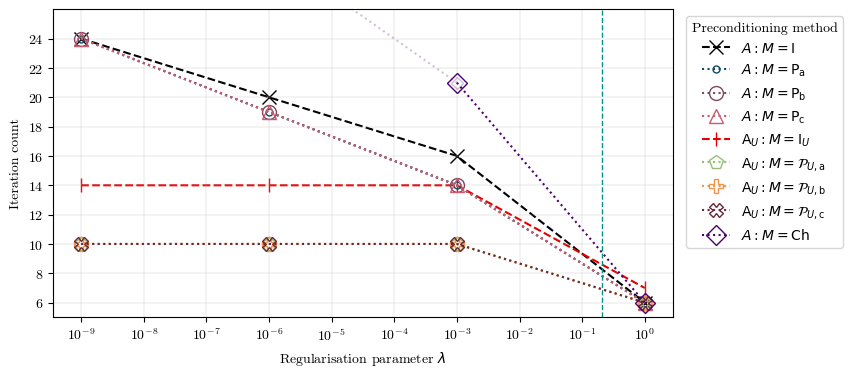

In [88]:
# Sample plot
fig, ax = plt.subplots(1, 1, figsize=(8,4))

# Retrieve iterations
All_CG = Results[scale]['Solvers']['CG_its'].copy() #[:,:-1]
# Retrieve status for masks
All_Status = Results[scale]['Solvers']['Status'].copy() #[:,:-1]
All_Status_c = All_Status.copy()
All_Status[All_Status < 1] = 1.0;        All_Status_c[All_Status_c > 1] = 1.0
All_Status[All_Status > 1] = np.nan;     All_Status_c[All_Status_c < 1] = np.nan

# Modify mask such that last point gets represented as well
for status in All_Status_c:
    nan_index = np.where( ~np.isnan(status) )[0]
    if nan_index.size > 0:
        status[nan_index[-1] + 1] = 1.0

        
'''
    Plot all lines at once
'''
Lines = plt.plot( Λ, (All_Status * All_CG).T, ':x', markersize = 10, label= legend_label)
[Lines[l].set_color( colours[l] ) for l in range(len(Lines)) ]

Lines_c = plt.plot( Λ, (All_Status_c * All_CG).T, ':x', alpha=0.25 )
[Lines_c[l].set_color( Lines[l].get_color() ) for l in range(len(Lines_c)) ]


# Modify marker and face colour of each line
[Lines[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]
[l.set_markerfacecolor( 'none' ) for l in Lines ];    [l.set_markerfacecolor( 'none' ) for l in Lines_c ]
[Lines_c[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]

# Different line type for unpreconditioned system
## Original base
Lines[0].set_color('black');    Lines[0].set_linestyle('--');    Lines[0].set_zorder(0)
Lines_c[0].set_color('black');  Lines_c[0].set_linestyle('--');  Lines_c[0].set_alpha(0.4)
## Unitary base
Lines[4].set_linestyle('--');    Lines[4].set_zorder(0)
Lines_c[4].set_linestyle('--');  Lines_c[4].set_alpha(0.4)


# Add eig
eig_min_max = Results[scale]['A_Eigs'][::-1]
dim_n = Results[scale]['Sizes'][2]
if eig_min_max[0] > Λ.min():
    plt.axvline(x=eig_min_max[0] * (dim_n)/(dim_n-1), color='xkcd:teal', linestyle='--', linewidth=1)
#if eig_min_max[1] < Λ.max():
#    plt.axvline(x=eig_min_max[1], color='xkcd:plum', linestyle='-', linewidth=0.5)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)

#plt.gca().xaxis.set_major_locator(MultipleLocator(1))
#   plt.title( '$n \\mathdefault{='+'{0:d}'.format(dim_n)+ '}$', fontname='CMR10')
plt.xscale('log')
leg = ax.legend(loc='upper left', ncol=1, framealpha=0.8, title = 'Preconditioning method', bbox_to_anchor=(1.01, 1),  prop={'family': 'CMR10'})
plt.setp(leg.get_title(), fontname='CMR10')
#fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3, bbox_transform=plt.gcf().transFigure, prop={'family': 'CMR10'})

plt.xlabel('Regularisation parameter $\lambda$', fontname='CMR10');    plt.ylabel('Iteration count', fontname='CMR10')

# Set vertical limits
y_inf = np.nanmin(All_Status * All_CG)
y_lim_inf = max( y_inf - 1, 0)
plt.ylim( y_lim_inf, min(np.nanmax(All_Status * All_CG) + 2, 30) )

# Add more ticks in x-axis
ax_base = list(range(-9,1))
ax_val  = [1]*10
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Fix integers in y axis
ax_val = np.arange( y_lim_inf if y_lim_inf % 2 == 0 else y_lim_inf - 1, np.nanmax(All_Status * All_CG) + 2, 2, dtype=int)[1:]
ax_lbl  = [plt.Text(a, 0, '$\\mathdefault{' + '{0}'.format(a) + '}$' )   for a in ax_val ]
#plt.yticks(ax_loc, ax_lbl )
ax.set_yticks(ax_val, ax_lbl, fontname='CMR10')


fig.savefig('Outputs/Trends_CG_test + Ch/CG_Its_Single_All.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [95]:
# 6 colours
colours = ['#000000','#80475E','#CC5A71',           'xkcd:red','#EE964B','#6B2737'     , 'xkcd:royal purple']

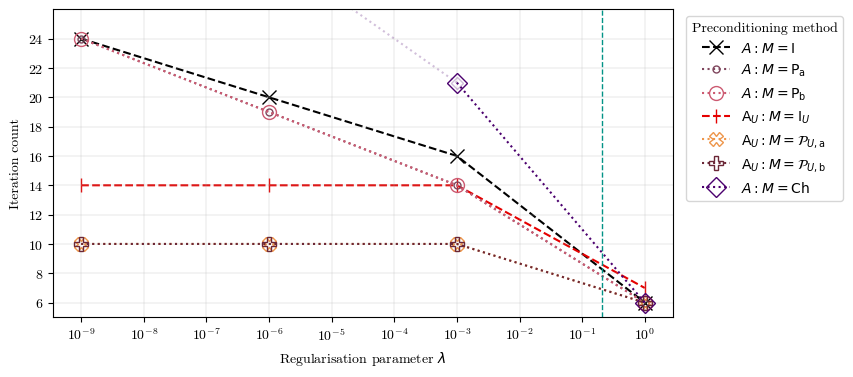

In [100]:
# Without P_c
fig, ax = plt.subplots(1, 1, figsize=(8,4))

line_markers = ['x', '.', 'o',   '|', 'X', 'P',  'D', '2', '*','3']

# Retrieve iterations
All_CG = Results[scale]['Solvers']['CG_its'][[0,1,2, 4,5,6, 8],:].copy()
# Retrieve status for masks
All_Status = Results[scale]['Solvers']['Status'][[0,1,2, 4,5,6, 8],:].copy()
All_Status_c = All_Status.copy()
All_Status[All_Status < 1] = 1.0;        All_Status_c[All_Status_c > 1] = 1.0
All_Status[All_Status > 1] = np.nan;     All_Status_c[All_Status_c < 1] = np.nan

# Modify mask such that last point gets represented as well
for status in All_Status_c:
    nan_index = np.where( ~np.isnan(status) )[0]
    if nan_index.size > 0:
        status[nan_index[-1] + 1] = 1.0

        
'''
    Plot all lines at once
'''
Lines = plt.plot( Λ, (All_Status * All_CG).T, ':x', markersize = 10, label= np.asarray(legend_label)[[0,1,2, 4,5,6, 8]] )
[Lines[l].set_color( colours[l] ) for l in range(len(Lines)) ]

Lines_c = plt.plot( Λ, (All_Status_c * All_CG).T, ':x', alpha=0.25 )
[Lines_c[l].set_color( Lines[l].get_color() ) for l in range(len(Lines_c)) ]


# Modify marker and face colour of each line
[Lines[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]
[l.set_markerfacecolor( 'none' ) for l in Lines ];    [l.set_markerfacecolor( 'none' ) for l in Lines_c ]
[Lines_c[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]

# Different line type for unpreconditioned system
## Original base
Lines[0].set_color('black');    Lines[0].set_linestyle('--');    Lines[0].set_zorder(0)
Lines_c[0].set_color('black');  Lines_c[0].set_linestyle('--');  Lines_c[0].set_alpha(0.4)
## Unitary base
Lines[3].set_linestyle('--');    Lines[3].set_zorder(0)
Lines_c[3].set_linestyle('--');  Lines_c[3].set_alpha(0.4)


# Add eig
eig_min_max = Results[scale]['A_Eigs'][::-1]
dim_n = Results[scale]['Sizes'][2]
if eig_min_max[0] > Λ.min():
    plt.axvline(x=eig_min_max[0] * (dim_n)/(dim_n-1), color='xkcd:teal', linestyle='--', linewidth=1)
#if eig_min_max[1] < Λ.max():
#    plt.axvline(x=eig_min_max[1], color='xkcd:plum', linestyle='-', linewidth=0.5)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)

#plt.gca().xaxis.set_major_locator(MultipleLocator(1))
#  plt.title( '$n \\mathdefault{='+'{0:d}'.format(dim_n)+ '}$', fontname='CMR10')
plt.xscale('log')
leg = ax.legend(loc='upper left', ncol=1, framealpha=0.8, title = 'Preconditioning method', bbox_to_anchor=(1.01, 1),  prop={'family': 'CMR10'})
plt.setp(leg.get_title(), fontname='CMR10')
#fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3, bbox_transform=plt.gcf().transFigure, prop={'family': 'CMR10'})

plt.xlabel('Regularisation parameter $\lambda$', fontname='CMR10');    plt.ylabel('Iteration count', fontname='CMR10')

# Set vertical limits
y_inf = np.nanmin(All_Status * All_CG)
y_lim_inf = max( y_inf - 1, 0)
plt.ylim( y_lim_inf, min(np.nanmax(All_Status * All_CG) + 2, 30) )

# Add more ticks in x-axis
ax_base = list(range(-9,1))
ax_val  = [1]*10
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Fix integers in y axis
ax_val = np.arange( y_lim_inf if y_lim_inf % 2 == 0 else y_lim_inf - 1, np.nanmax(All_Status * All_CG) + 2, 2, dtype=int)[1:]
ax_lbl  = [plt.Text(a, 0, '$\\mathdefault{' + '{0}'.format(a) + '}$' )   for a in ax_val ]
#plt.yticks(ax_loc, ax_lbl )
ax.set_yticks(ax_val, ax_lbl, fontname='CMR10')


fig.savefig('Outputs/Trends_CG_test + Ch/CG_Its_Single.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

---

In [107]:
# 9 colours
colours = ['#000000','#114B5F','#80475E','#CC5A71','xkcd:red','#95BF74','#EE964B','#6B2737', 'xkcd:royal purple']

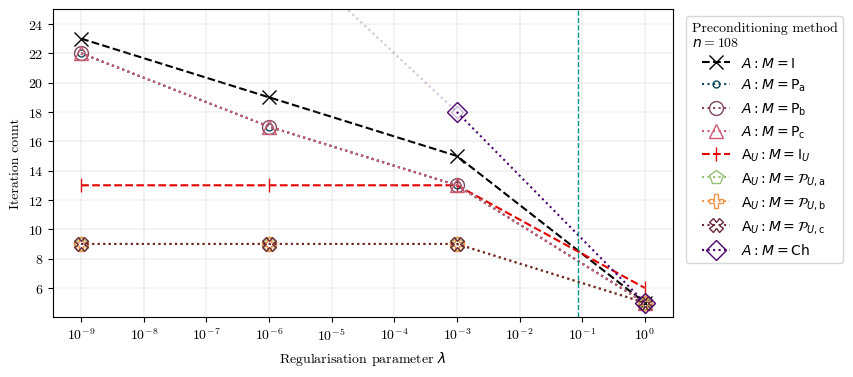

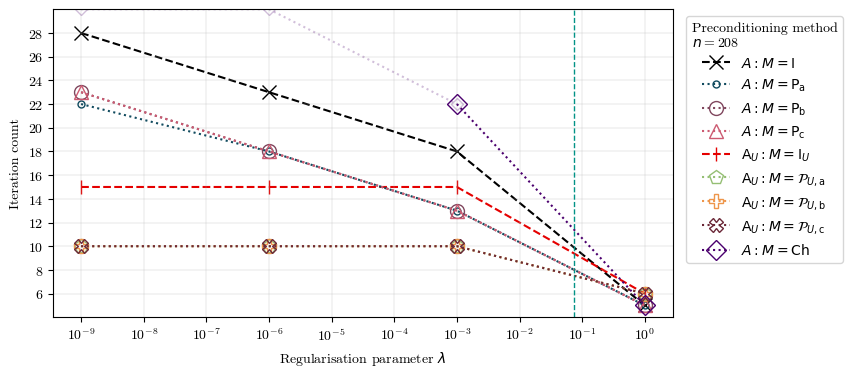

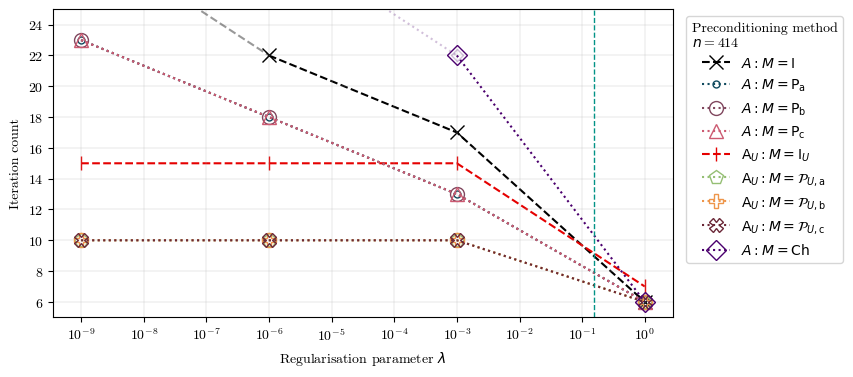

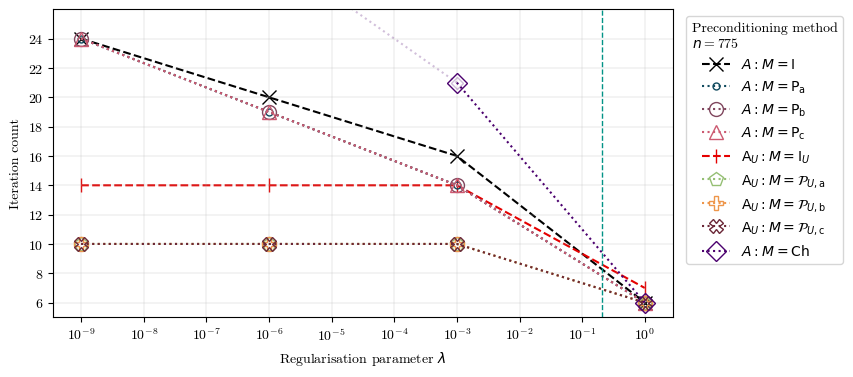

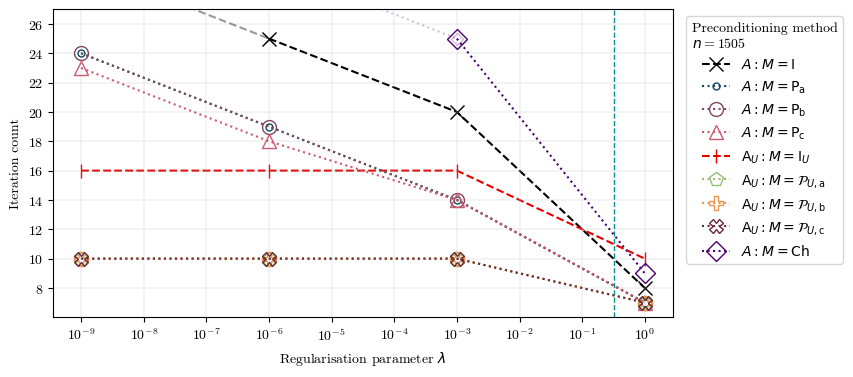

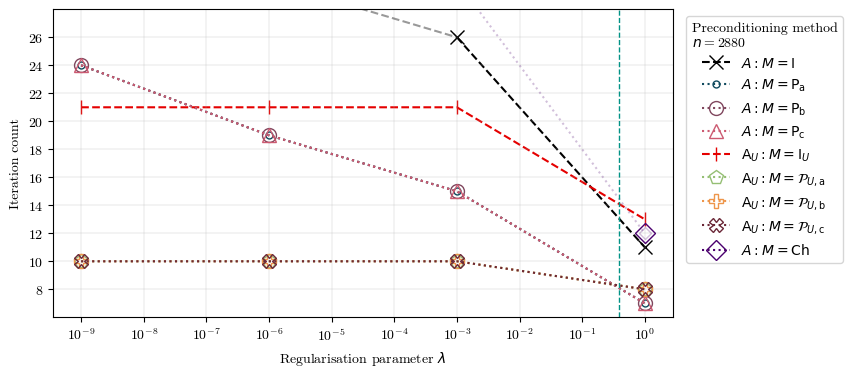

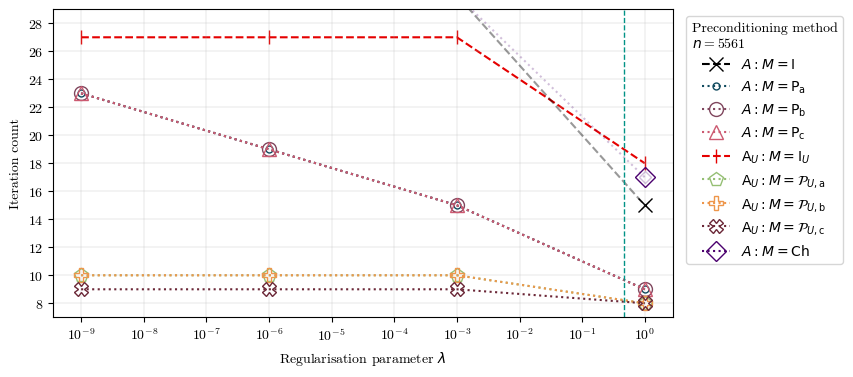

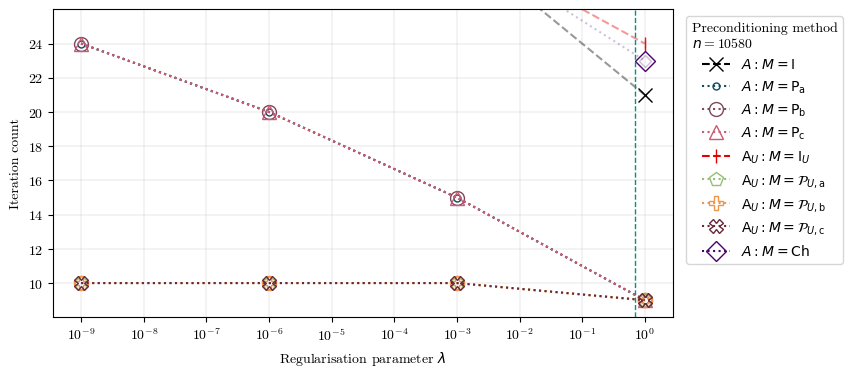

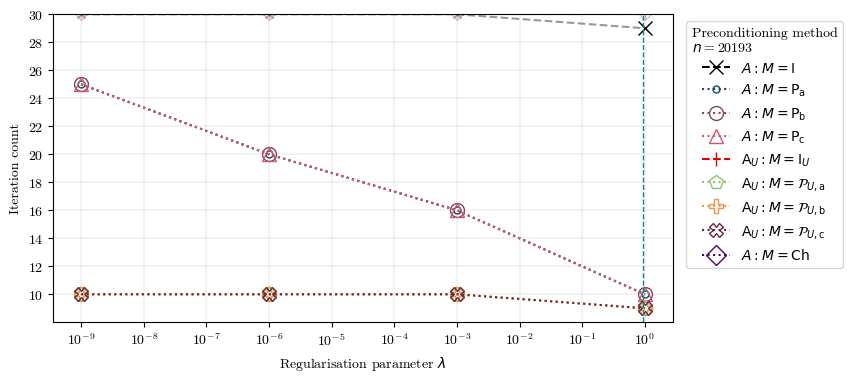

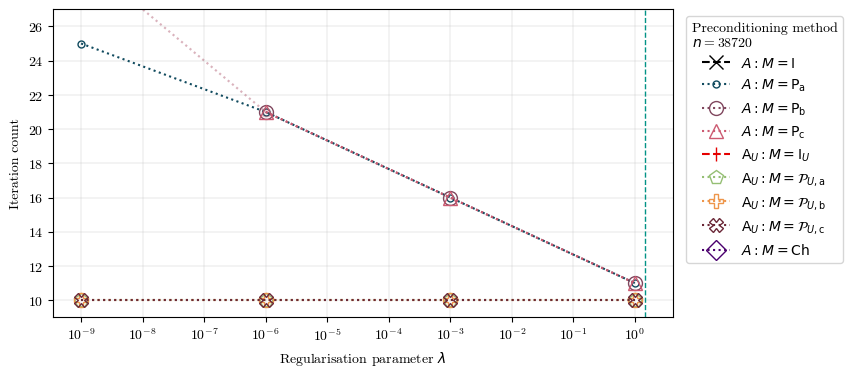

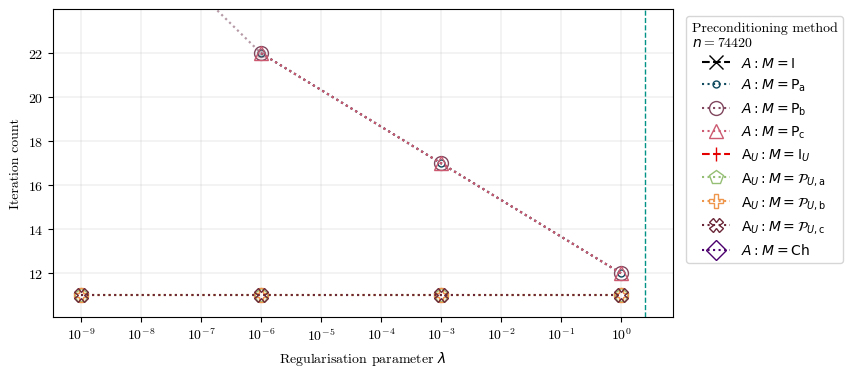

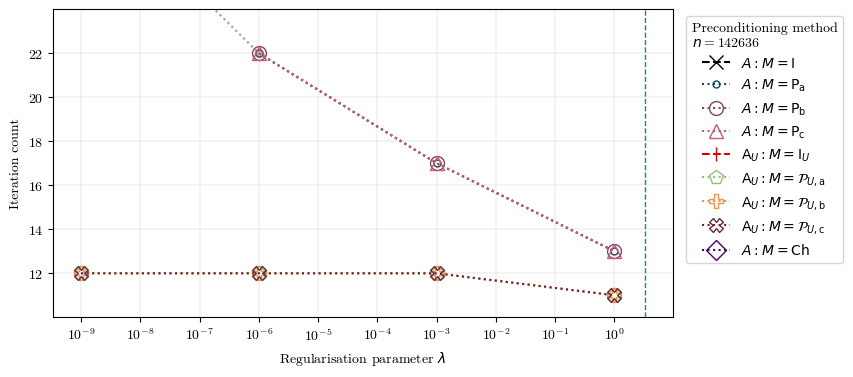

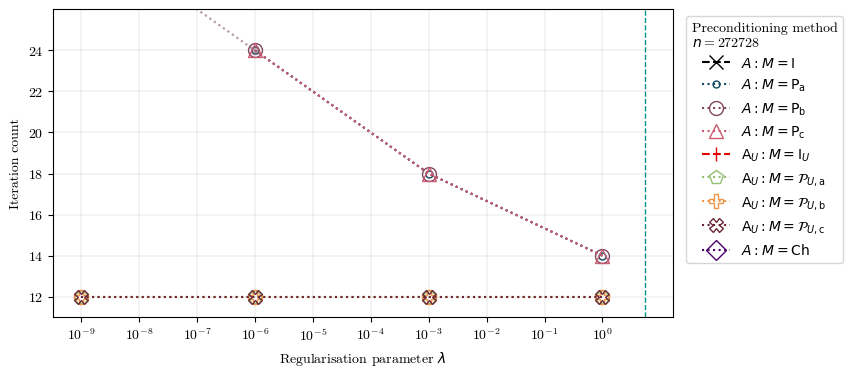

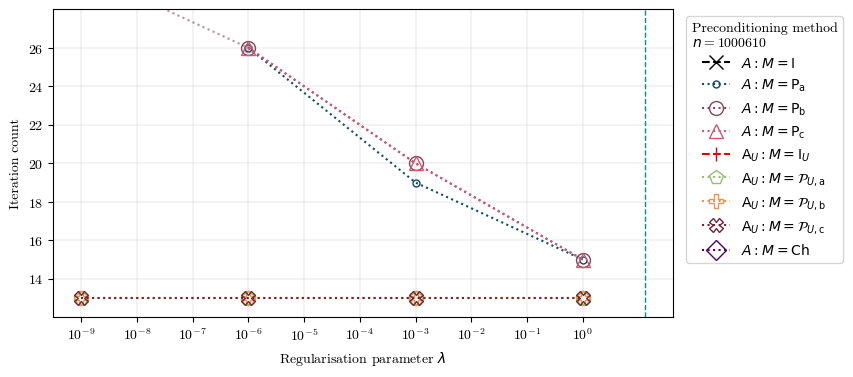

In [130]:
# All plots

for (scale_index, scale) in np.ndenumerate(Scales):

    fig, ax = plt.subplots(1, 1, figsize=(8,4))

    # Retrieve iterations
    All_CG = Results[scale]['Solvers']['CG_its'].copy() #[:,:-1]
    # Retrieve status for masks
    All_Status = Results[scale]['Solvers']['Status'].copy() #[:,:-1]
    All_Status_c = All_Status.copy()
    All_Status[All_Status < 1] = 1.0;        All_Status_c[All_Status_c > 1] = 1.0
    All_Status[All_Status > 1] = np.nan;     All_Status_c[All_Status_c < 1] = np.nan

    # Modify mask such that last point gets represented as well
    for status in All_Status_c:
        nan_index = np.where( ~np.isnan(status) )[0]
        if (nan_index.size > 0) and nan_index[-1] + 1 < status.size:
            status[nan_index[-1] + 1] = 1.0


    '''
        Plot all lines at once
    '''
    Lines = plt.plot( Λ, (All_Status * All_CG).T, ':x', markersize = 10, label= legend_label)
    [Lines[l].set_color( colours[l] ) for l in range(len(Lines)) ]

    Lines_c = plt.plot( Λ, (All_Status_c * All_CG).T, ':x', alpha=0.25 )
    [Lines_c[l].set_color( Lines[l].get_color() ) for l in range(len(Lines_c)) ]


    # Modify marker and face colour of each line
    [Lines[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]
    [l.set_markerfacecolor( 'none' ) for l in Lines ];    [l.set_markerfacecolor( 'none' ) for l in Lines_c ]
    [Lines_c[l].set_marker( line_markers[l] ) for l in range(len(Lines)) ]

    # Different line type for unpreconditioned system
    ## Original base
    Lines[0].set_color('black');    Lines[0].set_linestyle('--');    Lines[0].set_zorder(0)
    Lines_c[0].set_color('black');  Lines_c[0].set_linestyle('--');  Lines_c[0].set_alpha(0.4)
    ## Unitary base
    Lines[4].set_linestyle('--');    Lines[4].set_zorder(0)
    Lines_c[4].set_linestyle('--');  Lines_c[4].set_alpha(0.4)


    # Add eig
    eig_min_max = Results[scale]['A_Eigs'][::-1]
    dim_n = Results[scale]['Sizes'][2]
    if eig_min_max[0] > Λ.min():
        plt.axvline(x=eig_min_max[0] * (dim_n)/(dim_n-1), color='xkcd:teal', linestyle='--', linewidth=1)
    #if eig_min_max[1] < Λ.max():
    #    plt.axvline(x=eig_min_max[1], color='xkcd:plum', linestyle='-', linewidth=0.5)

    # Add grid lines
    plt.grid('on', which = 'major', linewidth = 0.2)

    #plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    #   plt.title( '$n \\mathdefault{='+'{0:d}'.format(dim_n)+ '}$', fontname='CMR10')
    plt.xscale('log')
    leg = plt.legend(loc='upper left', ncol=1, framealpha=0.8, title = 'Preconditioning method\n' + '$n \\mathdefault{='+'{0:d}'.format(dim_n)+ '}$', 
                     bbox_to_anchor=(1.01, 1),  prop={'family': 'CMR10'})
    plt.setp(leg.get_title(), fontname='CMR10')
    #fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3, bbox_transform=plt.gcf().transFigure, prop={'family': 'CMR10'})

    plt.xlabel('Regularisation parameter $\lambda$', fontname='CMR10');    plt.ylabel('Iteration count', fontname='CMR10')

    # Set vertical limits
    y_inf = np.nanmin(All_Status * All_CG)
    y_lim_inf = max( y_inf - 1, 0)
    plt.ylim( y_lim_inf, min(np.nanmax(All_Status * All_CG) + 2, 30) )

    # Add more ticks in x-axis
    ax_base = list(range(-9,1))
    ax_val  = [1]*10
    ax_loc  = ax_val * 10.0**asarray(ax_base)
    ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
               plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
               for a in zip(ax_loc, ax_base, ax_val) ]
    plt.xticks(ax_loc, ax_lbl )
    ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10')

    # Fix integers in y axis
    ax_val = np.arange( y_lim_inf if y_lim_inf % 2 == 0 else y_lim_inf - 1, np.nanmax(All_Status * All_CG) + 2, 2, dtype=int)[1:]
    ax_lbl  = [plt.Text(a, 0, '$\\mathdefault{' + '{0}'.format(a) + '}$' )   for a in ax_val ]
    #plt.yticks(ax_loc, ax_lbl )
    ax.set_yticks(ax_val, ax_lbl, fontname='CMR10')


    fig.savefig('Outputs/Trends_CG_test + Ch/CG_Its_Each_All_{0:2.2f}.pdf'.format(scale), bbox_inches='tight', pad_inches=0)

    plt.show()

---

## Other

### Storing images

```Python
from skimage.io import imsave

imsave('cell_small_noisy_upscaled.png', rescale(f, 1/0.1, anti_aliasing=True).astype(np.uint8))
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()
```

### Check version
```Python
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
```

### Found a faster $\Gamma v$:

In [89]:
def AK_a(u):
    """
    Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

    Note
    ----
    Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
    Any other variable needed has to be global, so that they can still be used within this function

    Parameters
    ----------
    u : ndarray
        The vector, whose product AK*u with the matrix AK shall be approximated.

    Returns
    -------
    AKu : ndarray
        The approximated matrix-vector product AK*u.
    """

    # Apply matrix-vector multiplication
    AKu = np.zeros_like(u)
    for l in range(num_windows):
        AKu += SubKernels[l].apply(u)

    # Multiply each subKernel by its weight and collect into a sum
    AKu *= k_weight

    return AKu

In [90]:
%timeit -n 10 -r 10   SubKernels[1].apply(u)

22.1 ms ± 1.08 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [91]:
%timeit -n 100 -r 5   AK(u)
%timeit -n 100 -r 5   AK_a(u)

454 ms ± 3.84 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)
360 ms ± 1.51 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)


---